<h1><center>GAN BAF</center></h1>

# Введение

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from typing_extensions import Literal
from IPython.display import clear_output
from tqdm import trange

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
DEVICE

device(type='cuda')

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer
import pickle

In [5]:
# Данные
path_baf = "D:/Work_dir/Master_work/Data/Bank_Account_Fraud_Dataset_Suite/Base.csv"

In [6]:
m_baf = "D:/Work_dir/Master_work/Experiments/4/GAN_BAF"

In [7]:
data = pd.read_csv(path_baf)

In [8]:
data.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [9]:
data[data.columns[data.dtypes == object]]

,payment_type,employment_status,housing_status,source,device_os
0,AA,CA,BA,INTERNET,windows
1,AB,CA,BA,INTERNET,windows
2,AC,CB,BA,INTERNET,other
3,AB,CA,BA,INTERNET,linux
4,AB,CA,BA,INTERNET,macintosh
...,...,...,...,...,...
999995,AB,CA,BC,INTERNET,linux
999996,AC,CC,BC,INTERNET,windows
999997,AA,CF,BC,INTERNET,other
999998,AA,CA,BA,INTERNET,windows


In [10]:
data.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [11]:
le = preprocessing.LabelEncoder()
for i in ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']:
    data[i] = le.fit_transform(data[i].astype(str))

In [12]:
# Сохраним QuantileTransformer
with open(f'{m_baf}/LE_BAF.pkl', 'wb') as fp:
    pickle.dump(le, fp)

In [13]:
names = data.columns[1:]

In [14]:
names

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [15]:
X = data.iloc[:, 1:]

In [16]:
y = data.iloc[:, 0]

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распделения значений каждого параметра для каждого типа.

In [17]:
def plot_hists(X1, X2, names, label1, label2): #bins=np.linspace(-500, 500, 100)
    plt.figure(figsize=(3*4, 10*2))
    for i in range(X1.shape[1]):
        plt.subplot(10, 4, i+1)
        plt.hist(X1[:, i], bins=25, alpha=0.5, label=label1, color='C0')
        plt.hist(X2[:, i], bins=25, alpha=0.5, label=label2, color='C1')
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()

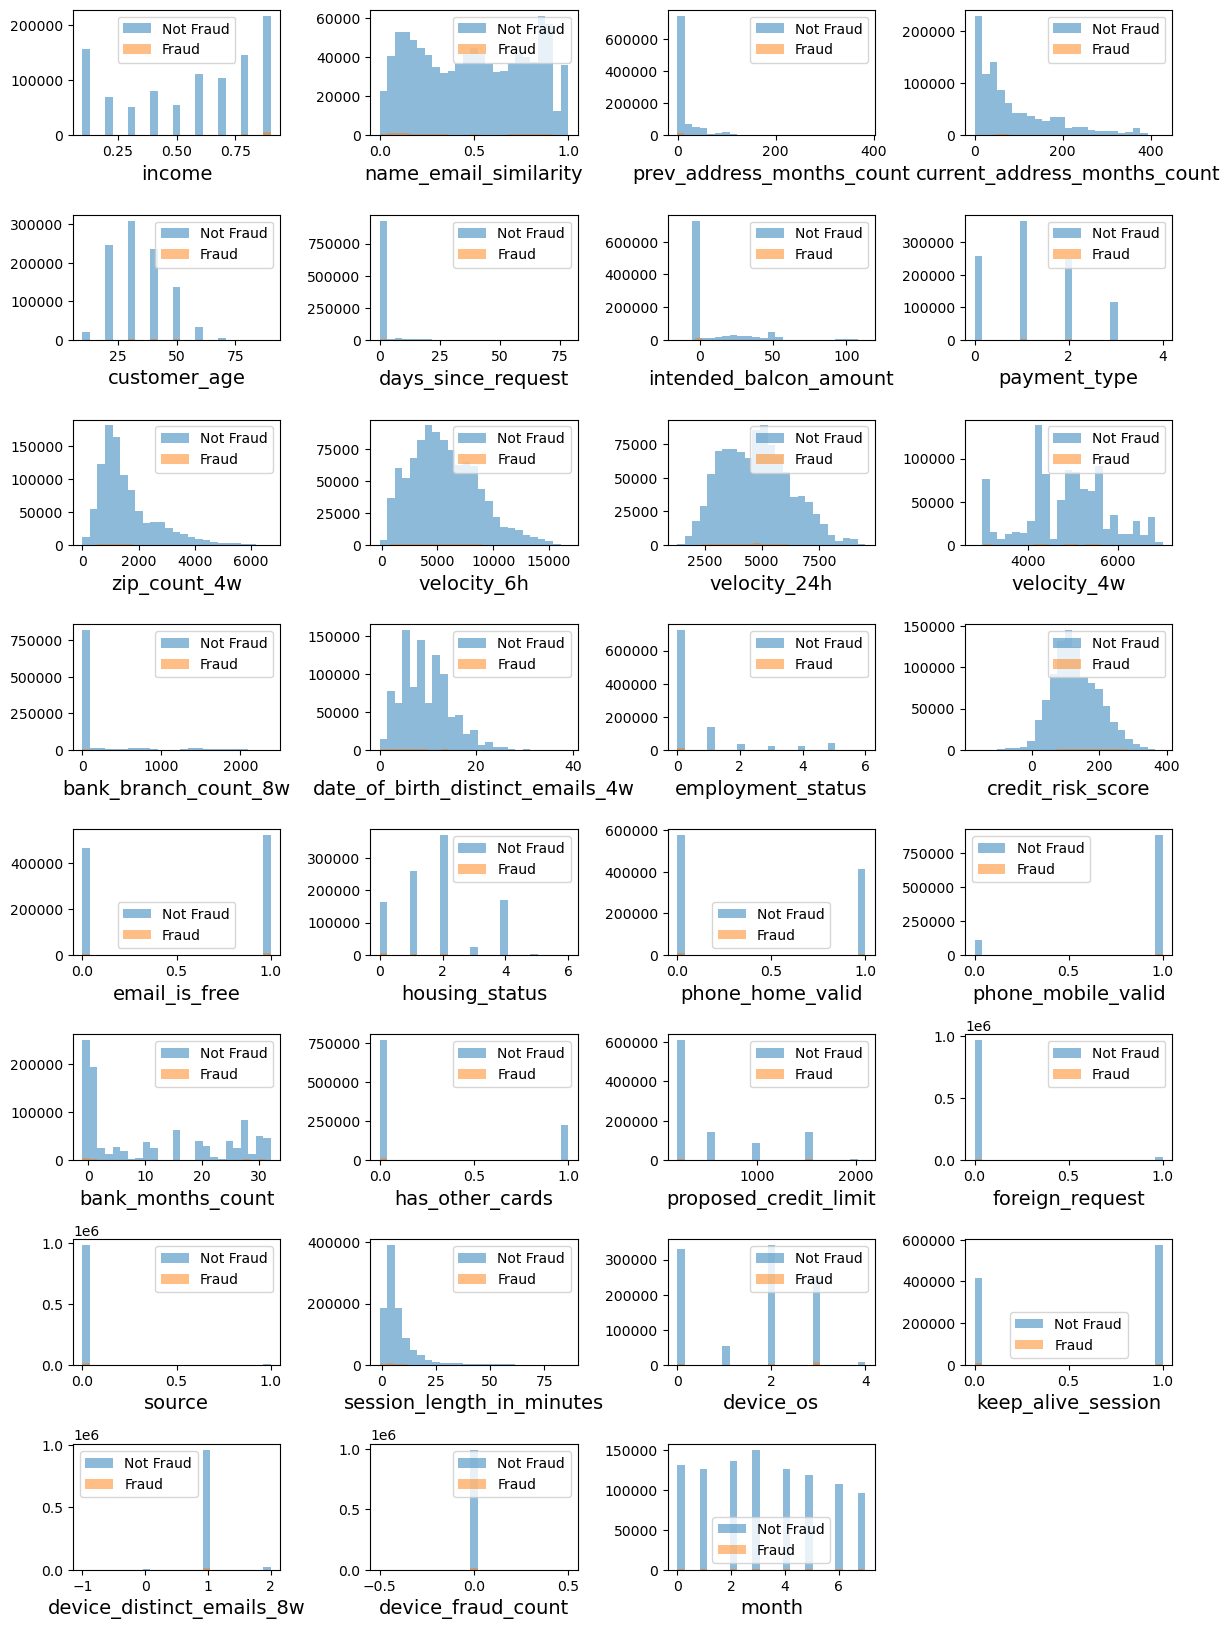

In [18]:
plot_hists(X[y==0].values, X[y==1].values, names, label1="Not Fraud", label2="Fraud")

# Приведем распределения к нормальным

In [19]:
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_qt = qt.fit_transform(X)

In [20]:
f'{m_baf}/QT_BAF.pkl'

'D:/Work_dir/Master_work/Experiments/4/GAN_BAF/QT_BAF.pkl'

In [21]:
# Сохраним QuantileTransformer
with open(f'{m_baf}/QT_BAF.pkl', 'wb') as fp:
    pickle.dump(qt, fp)

### Bспользуем SMOTE для балансировки данных

In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [23]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_qt, y.values)

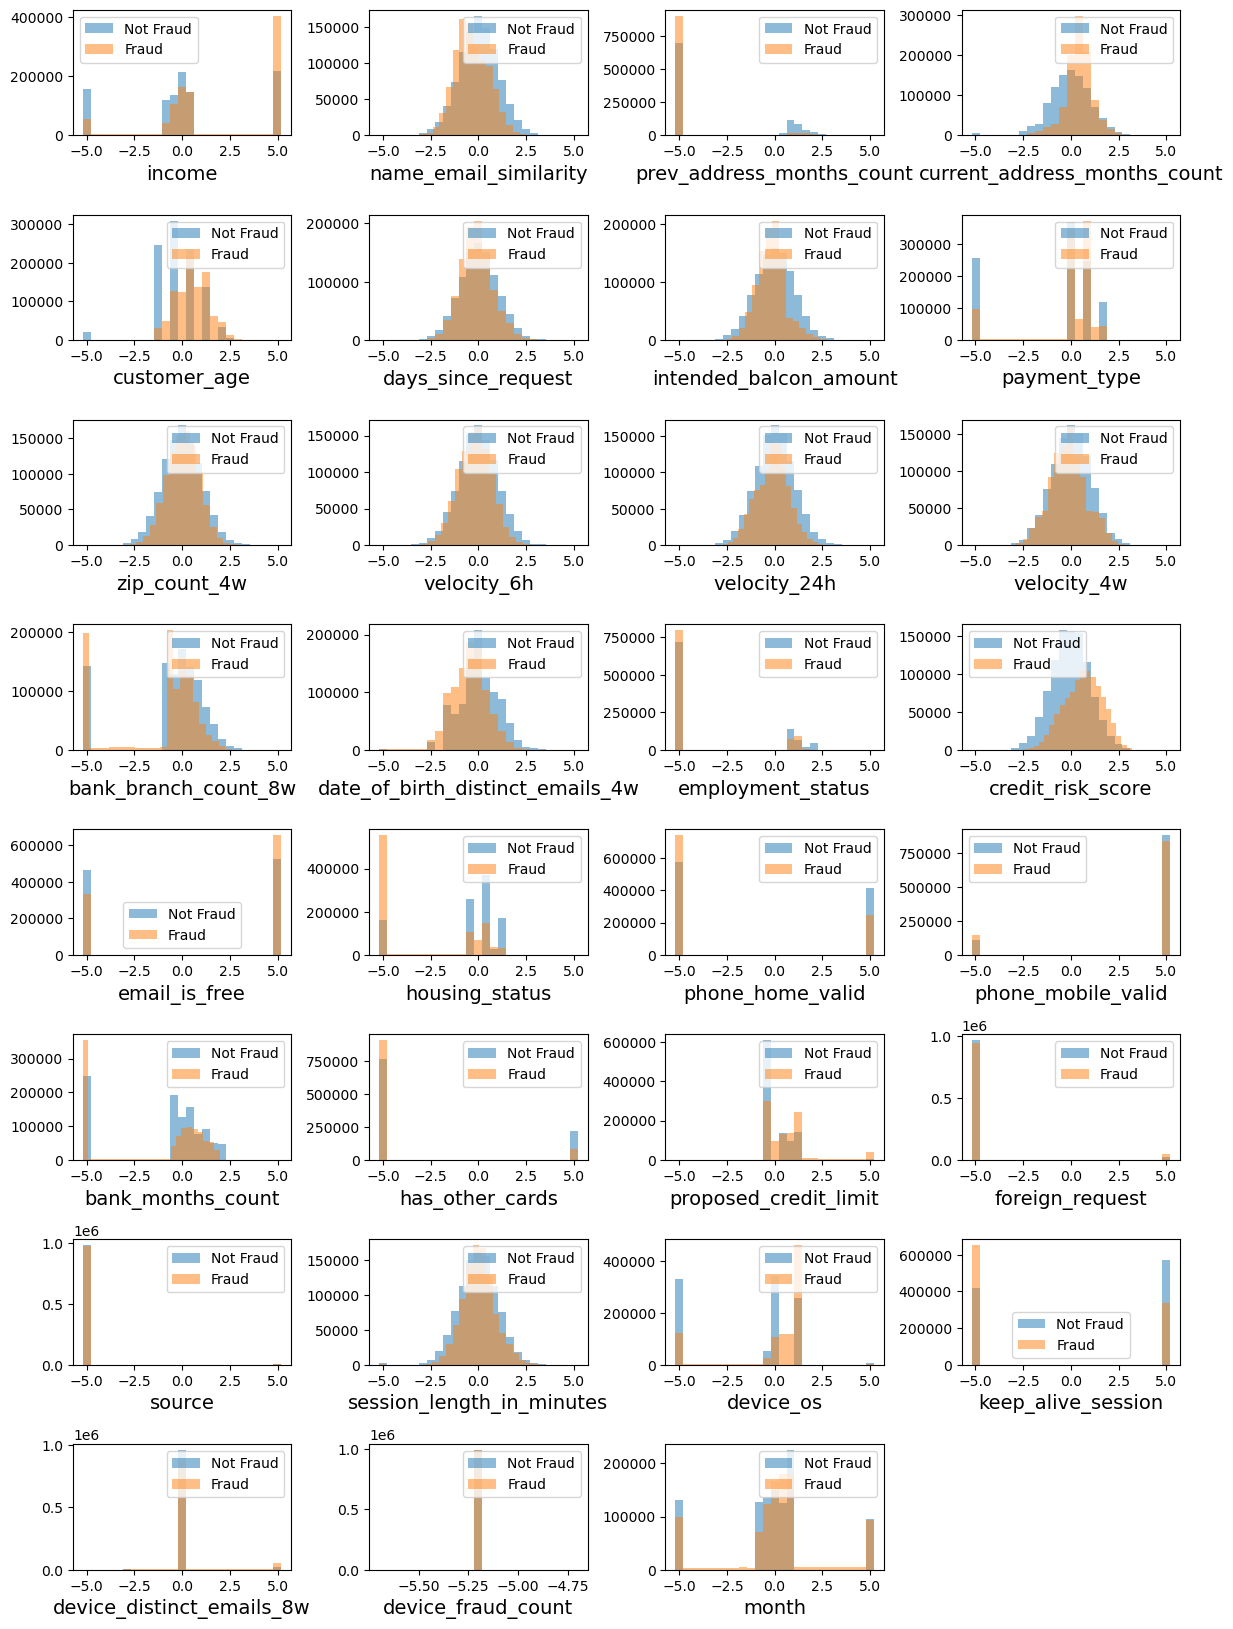

In [24]:
plot_hists(X_sm[y_sm==0], X_sm[y_sm==1], names, label1="Not Fraud", label2="Fraud")

# Обучающая и тестовая выборки

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, stratify=y_sm, test_size=0.5, shuffle=True, random_state=42)

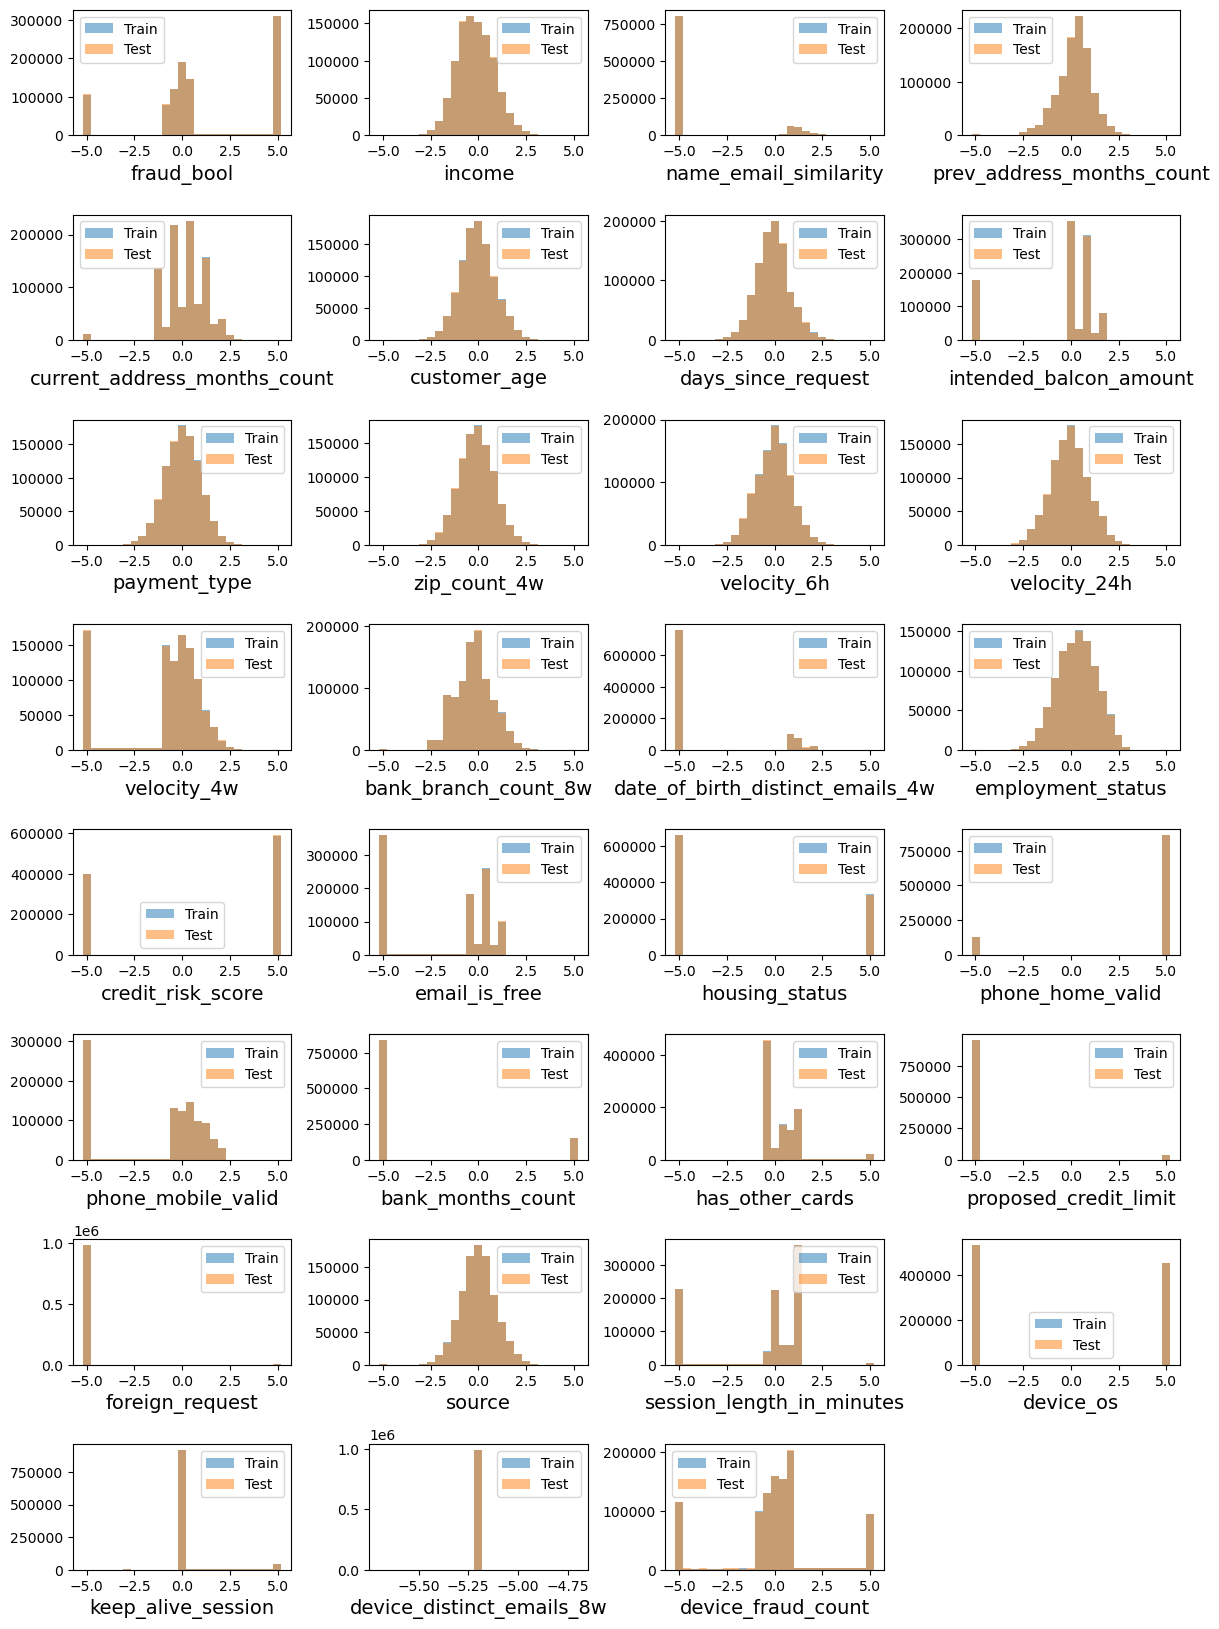

In [25]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - not fraud, **1** - fraud. Таким образом, мы будем сообщать генератору для какой транзакции нужно генерировать параметры. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [26]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
            
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(1000, 2000),
            nn.BatchNorm1d(2000, momentum=0.4),
            nn.Dropout(0.4),
            nn.ReLU(),
            
            nn.Linear(2000, 100),
            nn.BatchNorm1d(100, momentum=0.4),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(100, n_outputs)
            )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

In [27]:
class Discriminator(nn.Module):
    
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
                    nn.Linear(n_inputs, 1000),
                    #nn.BatchNorm1d(1000, momentum=0.6),
                    nn.Dropout(0.2),
                    nn.ReLU(),
            
                    nn.Linear(1000, 2000),
                    #nn.BatchNorm1d(2000, momentum=0.6),
                    nn.Dropout(0.2),
                    nn.ReLU(),
            
                    nn.Linear(2000, 100),
                    #nn.BatchNorm1d(1000, momentum=0.6),
                    nn.Dropout(0.2),
                    nn.ReLU(),
            
                    nn.Linear(100, 1),
                    nn.Sigmoid()
                    )

    def forward(self, x, y):
        #print(x.shape, y.shape)
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

In [28]:
class Fitter(object):
    
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
    
    def fit(self, X, y):
        
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        
        self.loss_history = []
        self.gen_loss_trace = []
        self.discr_loss_trace = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            
            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True), 0):          
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                # зададим цикл обучения дискриминатора (генератор/дискриминатоор   1 / 5)            
                
                # генерируем новые объекты
                z = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
                #print(z.shape, cond_batch.unsqueeze(1).shape)
                gen_batch = self.generator(z, cond_batch.unsqueeze(1))

                # считаем скоры
                #print(torch.cat([real_batch, gen_batch], dim=0).shape, torch.cat([cond_batch, cond_batch], dim=0).unsqueeze(1).shape)
                real_objects_scores, gen_objects_scores = torch.split(self.discriminator(
                torch.cat([real_batch, gen_batch], dim=0), 
                torch.cat([cond_batch, cond_batch], dim=0).unsqueeze(1)), len(real_batch))
                
                if i % self.n_critic == 0:
                    # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    
                    gen_loss = (torch.log(1 - gen_objects_scores).mean())
                    gen_loss.backward()
                    self.opt_gen.step()
                    self.gen_loss_trace.append(-gen_loss.item())
                else:
                    # делаем шаг обучения дискриминатора
                    self.opt_disc.zero_grad()

                    discr_loss = -torch.log(1 - gen_objects_scores).mean() - torch.log(real_objects_scores).mean()

                    discr_loss.backward()
                    self.opt_disc.step()
                    # ограничим веса
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                    self.discr_loss_trace.append(-discr_loss.item())
                    
                # Визуализация
                if i % 100 == 0:
                    clear_output(wait=True)
                    print(self.gen_loss_trace[-1])
                    plt.figure(figsize=(15, 5))

                    plt.subplot(1, 3, 1)
                    plt.xlabel('Iteration')
                    plt.ylabel('Generator loss')
                    plt.plot([i for i in range(1, len(self.gen_loss_trace)+1)], 
                             [p for p in self.gen_loss_trace])

                    plt.subplot(1, 3, 2)
                    plt.xlabel('Iteration')
                    plt.ylabel('Discriminator loss')
                    plt.plot([i for i in range(1, len(self.discr_loss_trace)+1)], 
                             [p for p in self.discr_loss_trace], color='orange')
                    
                    if len(self.loss_history) > 1:
                        print('Loss', self.loss_history[-1])
                        plt.subplot(1, 3, 3)
                        plt.xlabel("Epoch Number")
                        plt.ylabel("Loss Function")
                        plt.plot([i for i in range(epoch)], 
                                 [p for p in self.loss_history], color='green')
                    
                    plt.show()
                
            # caiculate and store loss after an epoch
            with torch.no_grad():
                loss_epoch = np.zeros(shape=[self.batch_size, 1])
                first = True
                for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=batch_size, shuffle=False), 0):          
                    X_batch = real_batch.to(DEVICE)
                    y_batch = cond_batch.to(DEVICE)
                    Z_batch = torch.normal(0, 1, (len(X_batch), self.latent_dim)).to(DEVICE)

                    X_fake = generator(Z_batch, y_batch.unsqueeze(1))
                    loss_batch = (self.discriminator(X_batch, y_batch.unsqueeze(1)) - self.discriminator(X_fake, y_batch.unsqueeze(1))).detach().cpu().numpy()
                    if first:
                        loss_epoch = loss_batch
                        first = False
                    else:
                        loss_epoch = np.vstack((loss_epoch, loss_batch))
                        
                self.loss_history.append(np.mean(loss_epoch, axis=0))
                torch.cuda.empty_cache()
            
                #Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
                #X_fake = self.generator(Z_noise, y_cond.unsqueeze(1))
                #loss_epoch = torch.mean(self.discriminator(X_real, y_cond.unsqueeze(1))) - torch.mean(self.discriminator(X_fake, y_cond.unsqueeze(1)))
                #self.loss_history.append(loss_epoch.detach().cpu())
                #torch.cuda.empty_cache()
                
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [29]:
batch_size=1024
n_epochs=9
latent_dim=32
lr=0.0005
n_critic=8

0.6007493734359741
Loss [0.02388652]


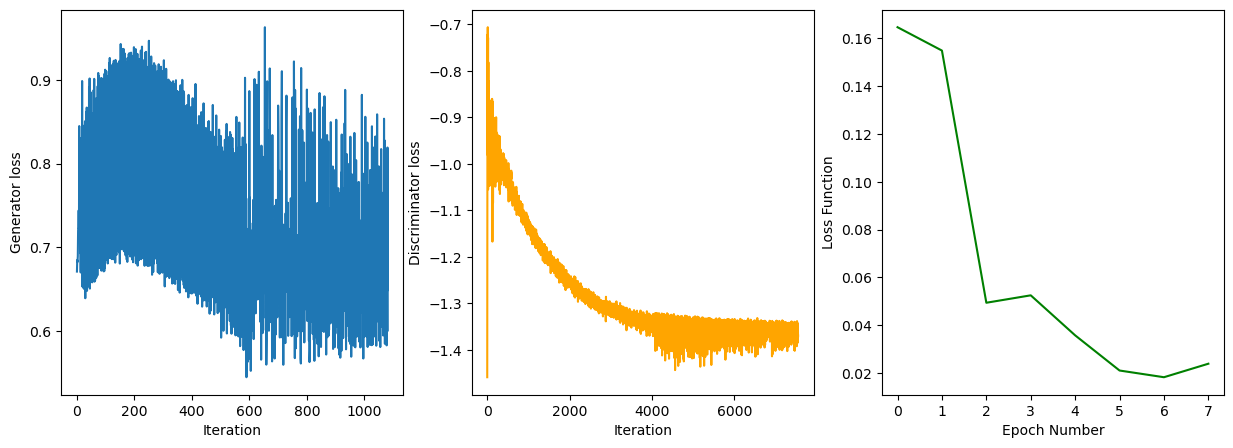

Wall time: 5min 11s


In [30]:
%%time
generator     = Generator(n_inputs=latent_dim+1, 
                          n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1]+1)

fitter = Fitter(generator, discriminator, batch_size=batch_size, n_epochs=n_epochs, latent_dim=latent_dim, lr=lr, n_critic=n_critic)
fitter.fit(X_train, y_train)

C:\Users\serge\AppData\Local\Temp\ipykernel_14856\3471976127.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')


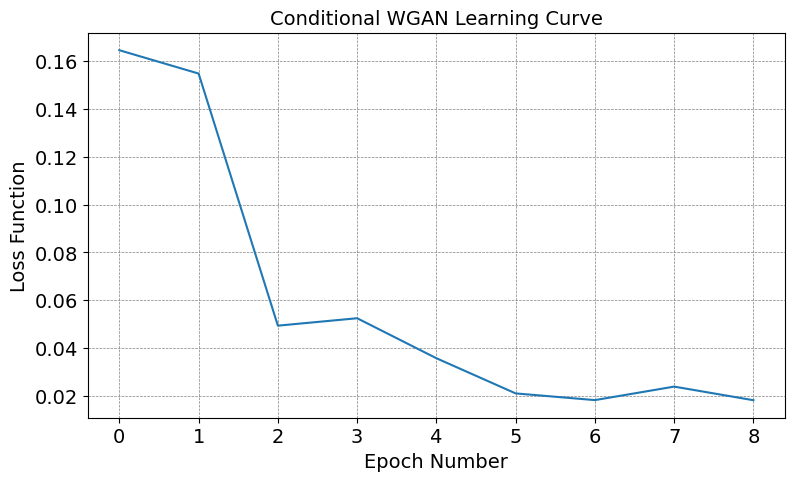

In [31]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

In [32]:
# Сохраним модель
torch.save(fitter.generator, f'{m_baf}/BAF_GAN.pt')

In [33]:
# Загрузим модель
model = torch.load(f'{m_baf}/BAF_GAN.pt')
model.eval()

Generator(
  (net): Sequential(
    (0): Linear(in_features=33, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=2000, bias=True)
    (5): BatchNorm1d(2000, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=2000, out_features=100, bias=True)
    (9): BatchNorm1d(100, eps=1e-05, momentum=0.4, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=31, bias=True)
  )
)

In [34]:
def generate(generator, y, latent_dim, batch_size):
    
    with torch.no_grad():
        Z_noise = torch.normal(0, 1, (len(y), latent_dim)).to(DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(Z_noise, y_cond)
        
        res = np.zeros(shape=[batch_size, Z_noise.shape[1]])
        first = True
        for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=batch_size, shuffle=False), 0):          
            Z_batch = real_batch.to(DEVICE)
            y_batch = cond_batch.to(DEVICE)
        
            gen_batch = generator(Z_batch, y_batch.unsqueeze(1)).detach().cpu().numpy()
            #print(gen_batch.shape)
            if first:
                res = gen_batch
                first = False
            else:
                res = np.vstack((res, gen_batch))
            torch.cuda.empty_cache()

    return res # numpy

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [35]:
X_fake_train = generate(model, y_train, latent_dim, batch_size)

In [36]:
X_fake_train.shape

(988971, 31)

In [37]:
X_train.shape

(988971, 31)

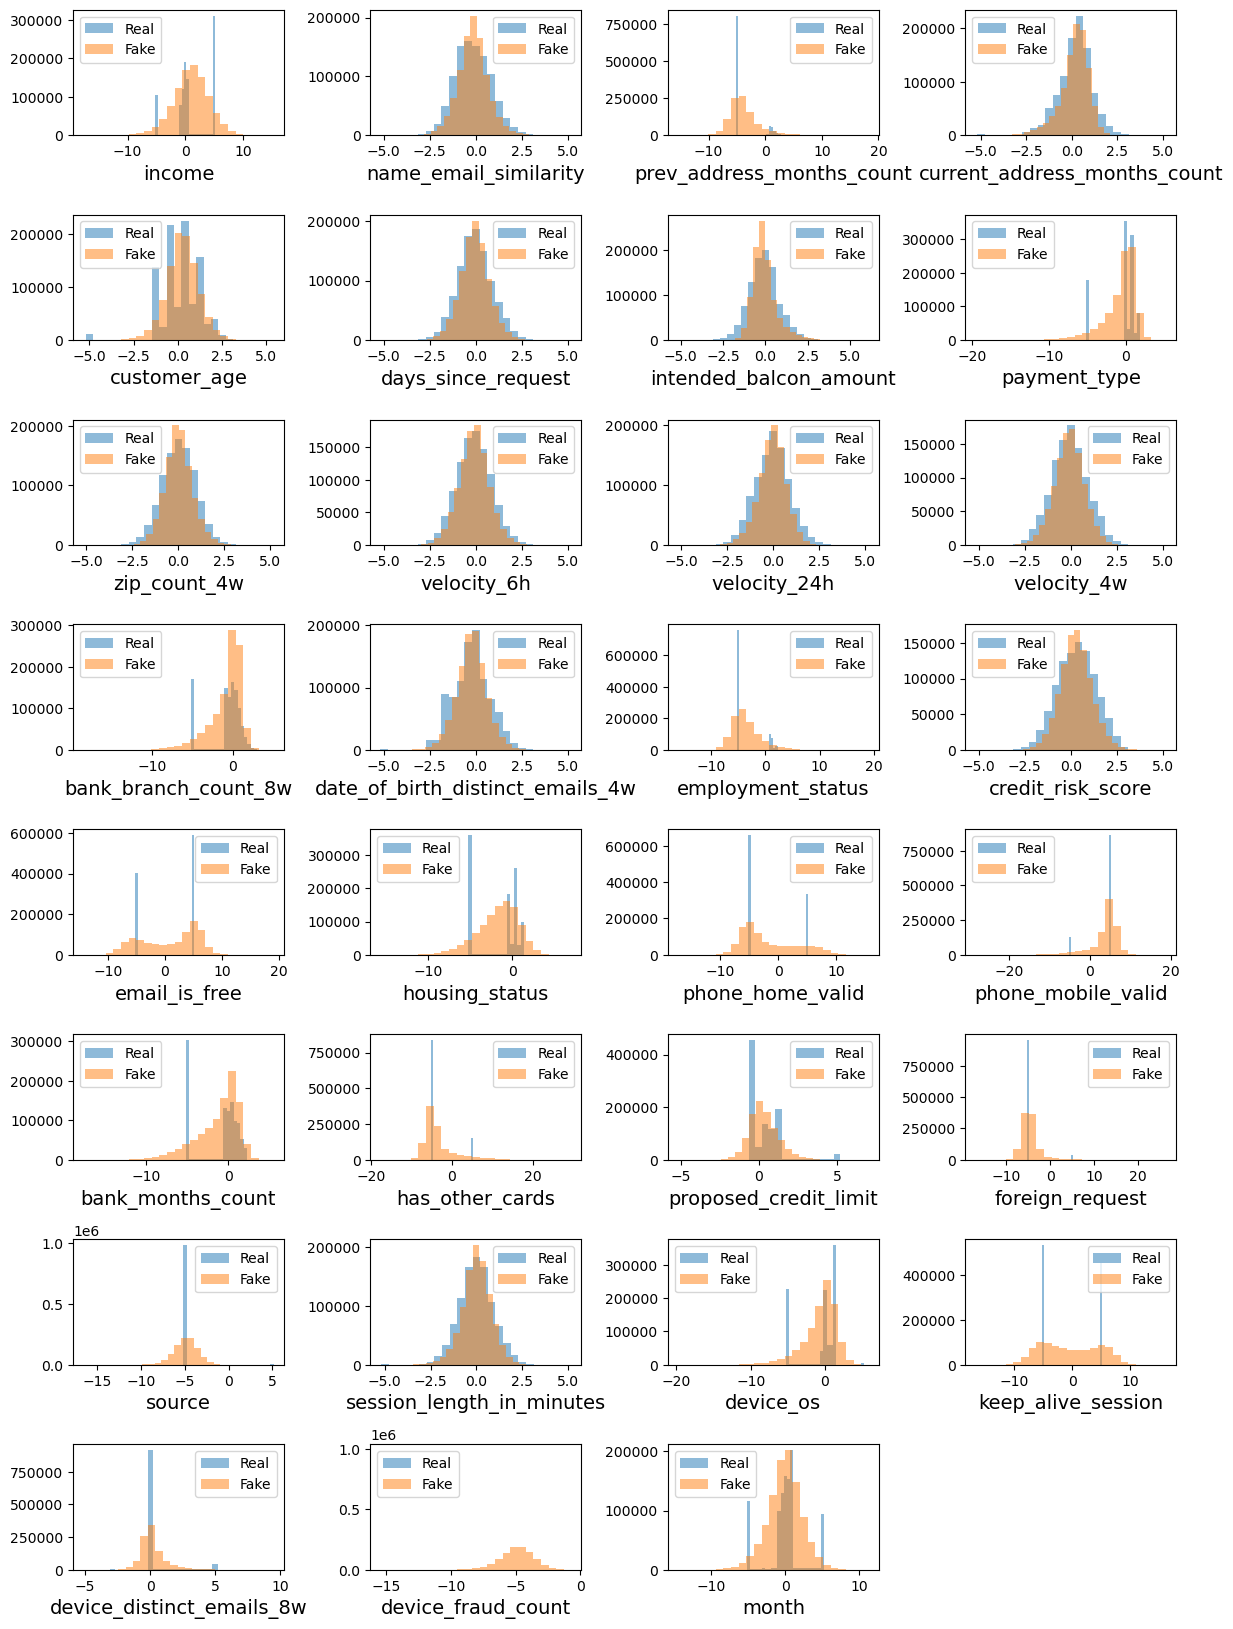

In [48]:
plot_hists(X_train, X_fake_train, names[1:], label1="Real", label2="Fake")

In [49]:
X_fake_test = generate(model, y_test, latent_dim, batch_size)

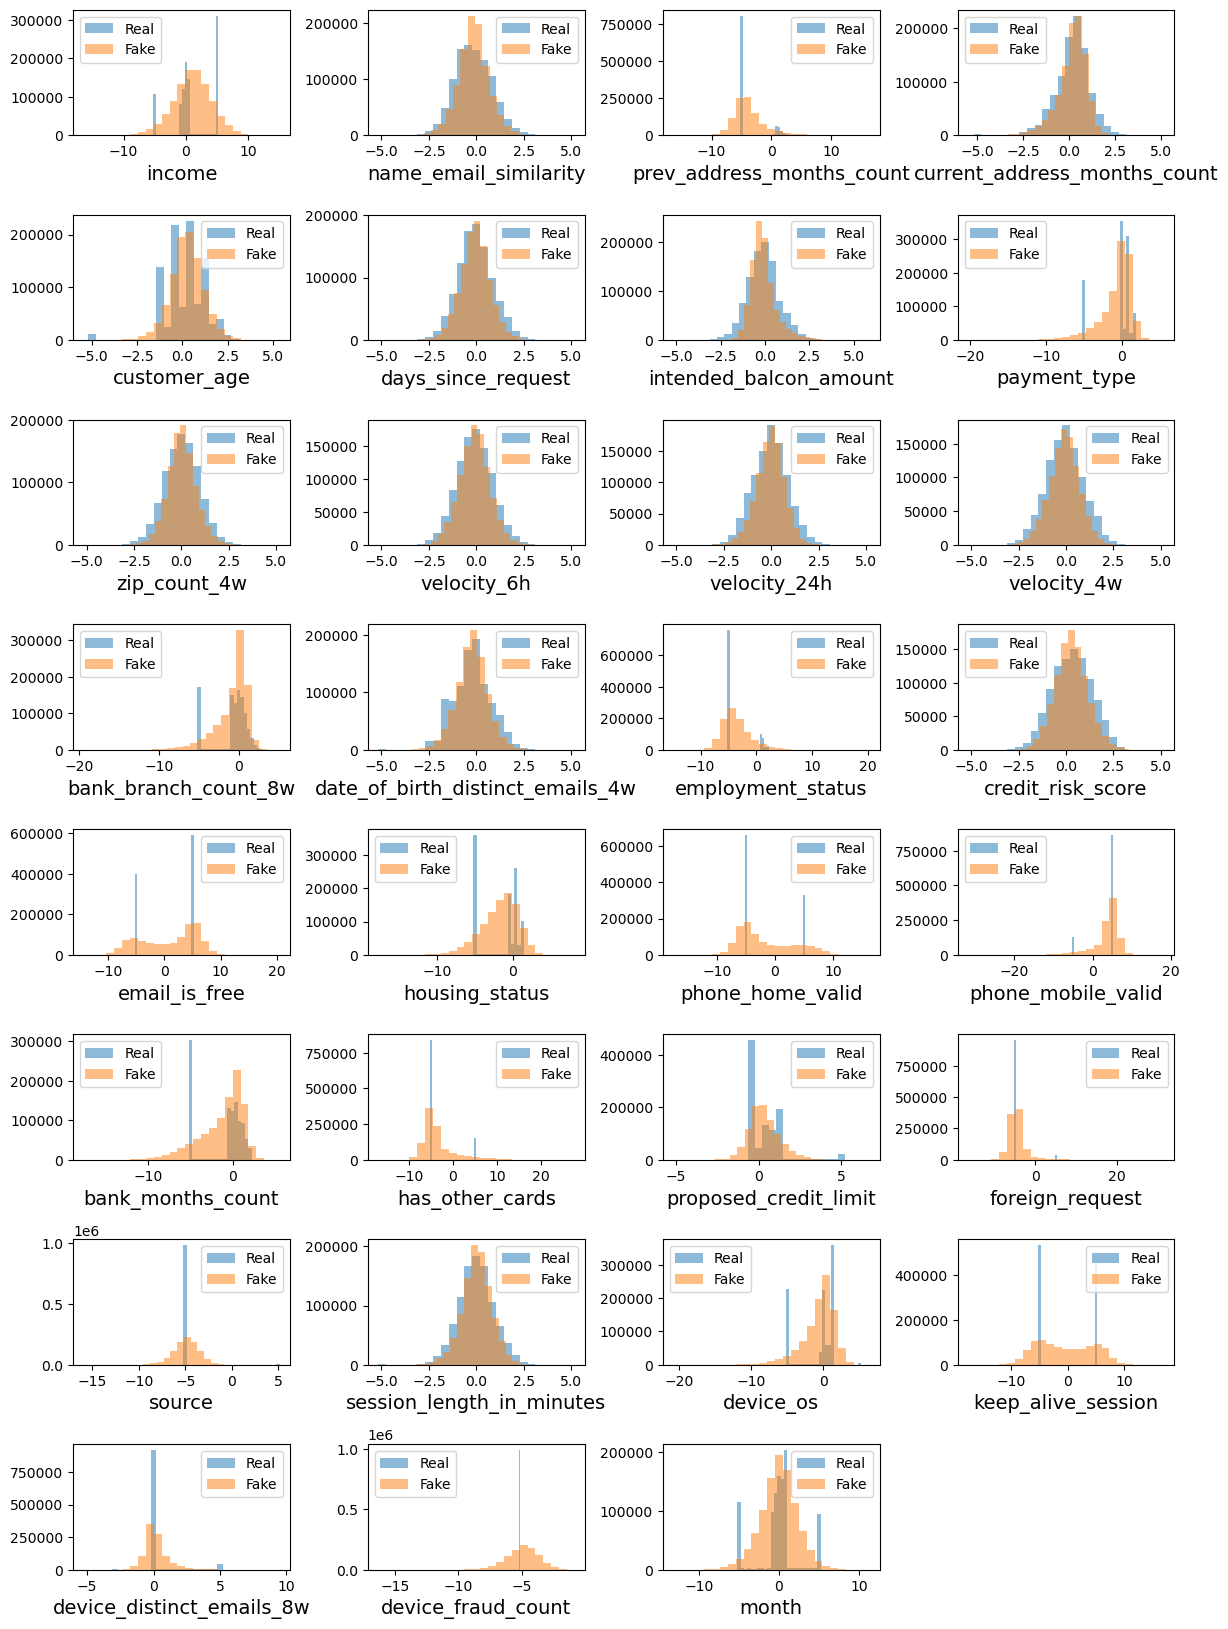

In [50]:
plot_hists(X_test, X_fake_test, names[1:], label1="Real", label2="Fake")

## Вывод

Идеальное значение ROC AUC равно 0.5. Это соответствует случаю, когда классификатор не может разделить реальные и фейковые данные. В нашем случае ROC AUC около 0.92, что говорит о том, что генератор не работает.

In [41]:
X_gen_qt_norm = generate(model, y, latent_dim, batch_size)

In [42]:
X_qt_inverse = qt.inverse_transform(X_qt)

C:\Users\serge\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [43]:
X_gen_qt = qt.inverse_transform(X_gen_qt_norm)

C:\Users\serge\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [44]:
type(X)

pandas.core.frame.DataFrame

In [45]:
type(X_qt_inverse)

numpy.ndarray

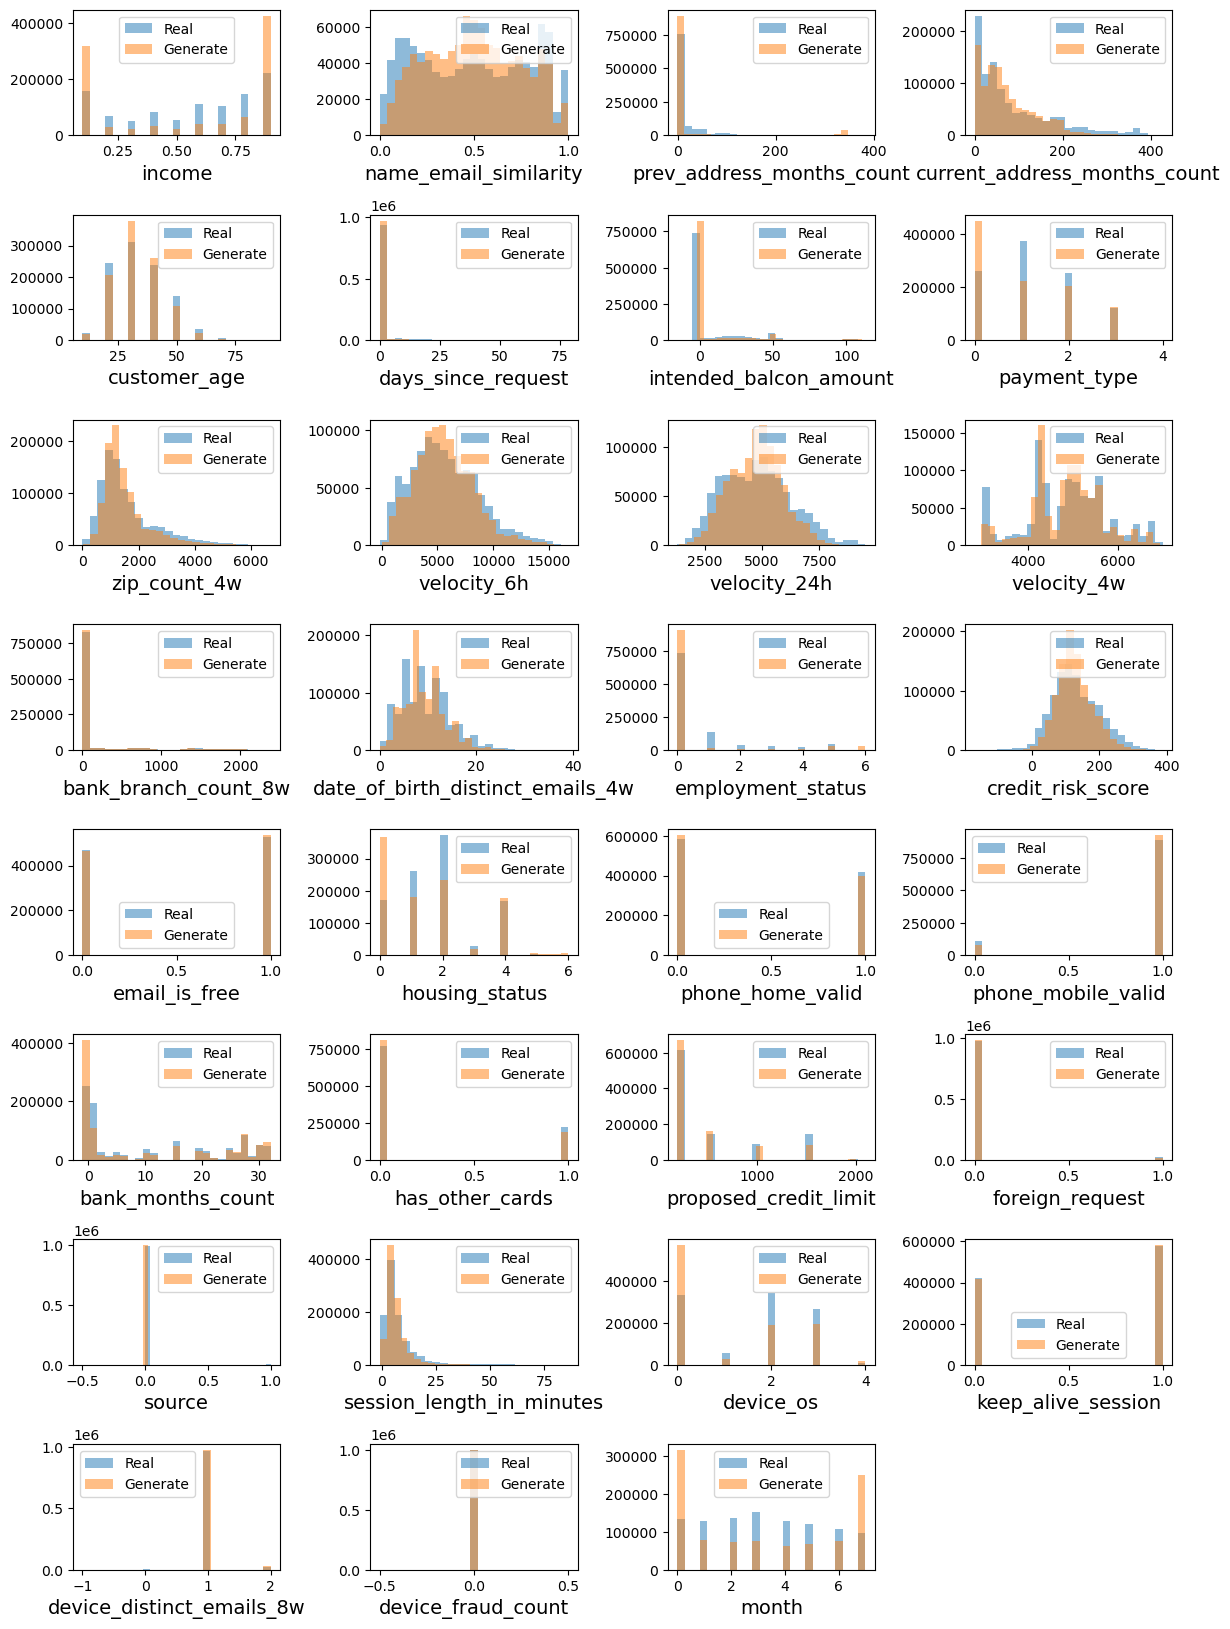

In [46]:
plot_hists(X.values, X_gen_qt, names[1:], label1="Real", label2="Generate")

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [56]:
# собираем реальный и фейковые матрицы в одну
XX = np.concatenate((X_gen_qt, X.values), axis=0)
#XX_test = np.concatenate((, X_test), axis=0)

yy = np.array([0]*len(X_gen_qt) + [1]*len(X.values))
#yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [57]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, stratify=yy, test_size=0.5, shuffle=True, random_state=42)

In [58]:
XX_train.shape

(1000000, 31)

In [59]:
yy_train.shape

(1000000,)

In [60]:
np.sum(yy_train)

500000

In [69]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score

In [63]:
# обучаем классификатор
clf = GradientBoostingClassifier()
#clf.fit(XX_train, yy_train)

# получаем прогнозы
#yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [64]:
#auc = roc_auc_score(yy_test, yy_test_proba)
#print("ROC AUC = ", auc)

In [66]:
CatBoost = CatBoostClassifier(iterations=5000,
                           eval_metric='F1',
                           learning_rate=0.009,
                           use_best_model=True,
                           random_state=42,
                           verbose=False,
                           task_type="GPU")

CatBoost.fit(XX_train, yy_train,
          verbose=True,
          eval_set = (XX_test, yy_test),
          plot=False)

0:	learn: 0.7442011	test: 0.7445269	best: 0.7445269 (0)	total: 17.6ms	remaining: 1m 27s
1:	learn: 0.7442011	test: 0.7445269	best: 0.7445269 (0)	total: 31.1ms	remaining: 1m 17s
2:	learn: 0.7488354	test: 0.7482741	best: 0.7482741 (2)	total: 43.3ms	remaining: 1m 12s
3:	learn: 0.7528098	test: 0.7520921	best: 0.7520921 (3)	total: 56.2ms	remaining: 1m 10s
4:	learn: 0.7518350	test: 0.7511171	best: 0.7520921 (3)	total: 69.4ms	remaining: 1m 9s
5:	learn: 0.7616395	test: 0.7615430	best: 0.7615430 (5)	total: 83ms	remaining: 1m 9s
6:	learn: 0.7606974	test: 0.7605594	best: 0.7615430 (5)	total: 96.4ms	remaining: 1m 8s
7:	learn: 0.7690869	test: 0.7687976	best: 0.7687976 (7)	total: 110ms	remaining: 1m 8s
8:	learn: 0.7838297	test: 0.7839107	best: 0.7839107 (8)	total: 123ms	remaining: 1m 8s
9:	learn: 0.8013979	test: 0.8014204	best: 0.8014204 (9)	total: 137ms	remaining: 1m 8s
10:	learn: 0.7967174	test: 0.7968043	best: 0.8014204 (9)	total: 151ms	remaining: 1m 8s
11:	learn: 0.8052820	test: 0.8053055	best: 0

96:	learn: 0.8731980	test: 0.8733277	best: 0.8742644 (93)	total: 1.26s	remaining: 1m 3s
97:	learn: 0.8730759	test: 0.8732552	best: 0.8742644 (93)	total: 1.28s	remaining: 1m 3s
98:	learn: 0.8745748	test: 0.8747322	best: 0.8747322 (98)	total: 1.29s	remaining: 1m 3s
99:	learn: 0.8747848	test: 0.8749246	best: 0.8749246 (99)	total: 1.3s	remaining: 1m 3s
100:	learn: 0.8747760	test: 0.8749477	best: 0.8749477 (100)	total: 1.32s	remaining: 1m 3s
101:	learn: 0.8762773	test: 0.8764653	best: 0.8764653 (101)	total: 1.33s	remaining: 1m 3s
102:	learn: 0.8755236	test: 0.8757264	best: 0.8764653 (101)	total: 1.34s	remaining: 1m 3s
103:	learn: 0.8777315	test: 0.8778838	best: 0.8778838 (103)	total: 1.36s	remaining: 1m 3s
104:	learn: 0.8771792	test: 0.8773141	best: 0.8778838 (103)	total: 1.37s	remaining: 1m 3s
105:	learn: 0.8780690	test: 0.8781805	best: 0.8781805 (105)	total: 1.38s	remaining: 1m 3s
106:	learn: 0.8774406	test: 0.8775143	best: 0.8781805 (105)	total: 1.39s	remaining: 1m 3s
107:	learn: 0.87757

203:	learn: 0.8933285	test: 0.8935874	best: 0.8935874 (203)	total: 2.5s	remaining: 58.9s
204:	learn: 0.8933092	test: 0.8935542	best: 0.8935874 (203)	total: 2.52s	remaining: 58.9s
205:	learn: 0.8934344	test: 0.8936793	best: 0.8936793 (205)	total: 2.53s	remaining: 58.9s
206:	learn: 0.8937125	test: 0.8939928	best: 0.8939928 (206)	total: 2.54s	remaining: 58.9s
207:	learn: 0.8938513	test: 0.8940921	best: 0.8940921 (207)	total: 2.56s	remaining: 58.9s
208:	learn: 0.8938310	test: 0.8940563	best: 0.8940921 (207)	total: 2.57s	remaining: 58.9s
209:	learn: 0.8940747	test: 0.8941859	best: 0.8941859 (209)	total: 2.58s	remaining: 58.9s
210:	learn: 0.8940750	test: 0.8942828	best: 0.8942828 (210)	total: 2.59s	remaining: 58.9s
211:	learn: 0.8940872	test: 0.8942706	best: 0.8942828 (210)	total: 2.61s	remaining: 58.9s
212:	learn: 0.8943995	test: 0.8945146	best: 0.8945146 (212)	total: 2.62s	remaining: 58.9s
213:	learn: 0.8944520	test: 0.8946262	best: 0.8946262 (213)	total: 2.63s	remaining: 58.9s
214:	learn:

300:	learn: 0.9043032	test: 0.9044817	best: 0.9044817 (300)	total: 3.78s	remaining: 59s
301:	learn: 0.9044246	test: 0.9046205	best: 0.9046205 (301)	total: 3.79s	remaining: 59s
302:	learn: 0.9046643	test: 0.9048494	best: 0.9048494 (302)	total: 3.81s	remaining: 59s
303:	learn: 0.9047967	test: 0.9049817	best: 0.9049817 (303)	total: 3.82s	remaining: 59s
304:	learn: 0.9050179	test: 0.9052109	best: 0.9052109 (304)	total: 3.83s	remaining: 59s
305:	learn: 0.9048705	test: 0.9050452	best: 0.9052109 (304)	total: 3.85s	remaining: 59s
306:	learn: 0.9051787	test: 0.9053545	best: 0.9053545 (306)	total: 3.86s	remaining: 59s
307:	learn: 0.9051276	test: 0.9053002	best: 0.9053545 (306)	total: 3.87s	remaining: 59s
308:	learn: 0.9051830	test: 0.9053672	best: 0.9053672 (308)	total: 3.88s	remaining: 59s
309:	learn: 0.9051600	test: 0.9053532	best: 0.9053672 (308)	total: 3.9s	remaining: 59s
310:	learn: 0.9054274	test: 0.9056742	best: 0.9056742 (310)	total: 3.91s	remaining: 58.9s
311:	learn: 0.9056981	test: 0.9

395:	learn: 0.9126815	test: 0.9129410	best: 0.9129410 (395)	total: 5.02s	remaining: 58.3s
396:	learn: 0.9127554	test: 0.9130151	best: 0.9130151 (396)	total: 5.03s	remaining: 58.3s
397:	learn: 0.9128046	test: 0.9130751	best: 0.9130751 (397)	total: 5.04s	remaining: 58.3s
398:	learn: 0.9127915	test: 0.9130247	best: 0.9130751 (397)	total: 5.05s	remaining: 58.3s
399:	learn: 0.9128302	test: 0.9130557	best: 0.9130751 (397)	total: 5.07s	remaining: 58.3s
400:	learn: 0.9128803	test: 0.9131034	best: 0.9131034 (400)	total: 5.08s	remaining: 58.2s
401:	learn: 0.9130512	test: 0.9132568	best: 0.9132568 (401)	total: 5.09s	remaining: 58.2s
402:	learn: 0.9131526	test: 0.9133761	best: 0.9133761 (402)	total: 5.1s	remaining: 58.2s
403:	learn: 0.9131379	test: 0.9133202	best: 0.9133761 (402)	total: 5.12s	remaining: 58.2s
404:	learn: 0.9131759	test: 0.9133878	best: 0.9133878 (404)	total: 5.13s	remaining: 58.2s
405:	learn: 0.9132008	test: 0.9134114	best: 0.9134114 (405)	total: 5.14s	remaining: 58.2s
406:	learn:

492:	learn: 0.9174825	test: 0.9176975	best: 0.9176975 (492)	total: 6.28s	remaining: 57.4s
493:	learn: 0.9176443	test: 0.9178860	best: 0.9178860 (493)	total: 6.29s	remaining: 57.4s
494:	learn: 0.9176904	test: 0.9179405	best: 0.9179405 (494)	total: 6.31s	remaining: 57.4s
495:	learn: 0.9177207	test: 0.9179675	best: 0.9179675 (495)	total: 6.32s	remaining: 57.4s
496:	learn: 0.9177506	test: 0.9180144	best: 0.9180144 (496)	total: 6.33s	remaining: 57.4s
497:	learn: 0.9177506	test: 0.9179923	best: 0.9180144 (496)	total: 6.35s	remaining: 57.4s
498:	learn: 0.9177593	test: 0.9180442	best: 0.9180442 (498)	total: 6.36s	remaining: 57.4s
499:	learn: 0.9177972	test: 0.9180997	best: 0.9180997 (499)	total: 6.38s	remaining: 57.4s
500:	learn: 0.9179897	test: 0.9182658	best: 0.9182658 (500)	total: 6.39s	remaining: 57.4s
501:	learn: 0.9179951	test: 0.9182731	best: 0.9182731 (501)	total: 6.4s	remaining: 57.4s
502:	learn: 0.9180824	test: 0.9183498	best: 0.9183498 (502)	total: 6.42s	remaining: 57.4s
503:	learn:

588:	learn: 0.9223459	test: 0.9224092	best: 0.9224092 (588)	total: 7.54s	remaining: 56.5s
589:	learn: 0.9224357	test: 0.9224681	best: 0.9224681 (589)	total: 7.55s	remaining: 56.5s
590:	learn: 0.9224676	test: 0.9224723	best: 0.9224723 (590)	total: 7.57s	remaining: 56.5s
591:	learn: 0.9225056	test: 0.9225096	best: 0.9225096 (591)	total: 7.58s	remaining: 56.5s
592:	learn: 0.9225216	test: 0.9225274	best: 0.9225274 (592)	total: 7.59s	remaining: 56.5s
593:	learn: 0.9225325	test: 0.9225478	best: 0.9225478 (593)	total: 7.61s	remaining: 56.4s
594:	learn: 0.9225434	test: 0.9225522	best: 0.9225522 (594)	total: 7.62s	remaining: 56.4s
595:	learn: 0.9225545	test: 0.9225453	best: 0.9225522 (594)	total: 7.64s	remaining: 56.4s
596:	learn: 0.9225332	test: 0.9225903	best: 0.9225903 (596)	total: 7.65s	remaining: 56.4s
597:	learn: 0.9225702	test: 0.9226173	best: 0.9226173 (597)	total: 7.66s	remaining: 56.4s
598:	learn: 0.9226164	test: 0.9226322	best: 0.9226322 (598)	total: 7.68s	remaining: 56.4s
599:	learn

682:	learn: 0.9258320	test: 0.9258829	best: 0.9258829 (682)	total: 8.78s	remaining: 55.5s
683:	learn: 0.9258627	test: 0.9259279	best: 0.9259279 (683)	total: 8.8s	remaining: 55.5s
684:	learn: 0.9258918	test: 0.9259467	best: 0.9259467 (684)	total: 8.81s	remaining: 55.5s
685:	learn: 0.9259251	test: 0.9259644	best: 0.9259644 (685)	total: 8.82s	remaining: 55.5s
686:	learn: 0.9259528	test: 0.9259950	best: 0.9259950 (686)	total: 8.84s	remaining: 55.5s
687:	learn: 0.9260028	test: 0.9260331	best: 0.9260331 (687)	total: 8.85s	remaining: 55.5s
688:	learn: 0.9260570	test: 0.9261267	best: 0.9261267 (688)	total: 8.86s	remaining: 55.5s
689:	learn: 0.9260872	test: 0.9261724	best: 0.9261724 (689)	total: 8.88s	remaining: 55.4s
690:	learn: 0.9261100	test: 0.9261826	best: 0.9261826 (690)	total: 8.89s	remaining: 55.4s
691:	learn: 0.9261423	test: 0.9262208	best: 0.9262208 (691)	total: 8.9s	remaining: 55.4s
692:	learn: 0.9261778	test: 0.9262509	best: 0.9262509 (692)	total: 8.92s	remaining: 55.4s
693:	learn: 

777:	learn: 0.9288382	test: 0.9289675	best: 0.9289675 (777)	total: 10s	remaining: 54.5s
778:	learn: 0.9288386	test: 0.9289863	best: 0.9289863 (778)	total: 10.1s	remaining: 54.5s
779:	learn: 0.9288850	test: 0.9290140	best: 0.9290140 (779)	total: 10.1s	remaining: 54.5s
780:	learn: 0.9288827	test: 0.9290235	best: 0.9290235 (780)	total: 10.1s	remaining: 54.5s
781:	learn: 0.9288982	test: 0.9290374	best: 0.9290374 (781)	total: 10.1s	remaining: 54.5s
782:	learn: 0.9289166	test: 0.9290457	best: 0.9290457 (782)	total: 10.1s	remaining: 54.4s
783:	learn: 0.9289437	test: 0.9290686	best: 0.9290686 (783)	total: 10.1s	remaining: 54.4s
784:	learn: 0.9289510	test: 0.9290673	best: 0.9290686 (783)	total: 10.1s	remaining: 54.4s
785:	learn: 0.9290011	test: 0.9290951	best: 0.9290951 (785)	total: 10.1s	remaining: 54.4s
786:	learn: 0.9290351	test: 0.9291242	best: 0.9291242 (786)	total: 10.2s	remaining: 54.4s
787:	learn: 0.9290446	test: 0.9291377	best: 0.9291377 (787)	total: 10.2s	remaining: 54.4s
788:	learn: 

873:	learn: 0.9311170	test: 0.9311403	best: 0.9311403 (873)	total: 11.3s	remaining: 53.4s
874:	learn: 0.9311327	test: 0.9311488	best: 0.9311488 (874)	total: 11.3s	remaining: 53.4s
875:	learn: 0.9311495	test: 0.9311532	best: 0.9311532 (875)	total: 11.3s	remaining: 53.4s
876:	learn: 0.9311506	test: 0.9311875	best: 0.9311875 (876)	total: 11.4s	remaining: 53.4s
877:	learn: 0.9311740	test: 0.9312204	best: 0.9312204 (877)	total: 11.4s	remaining: 53.4s
878:	learn: 0.9311645	test: 0.9312048	best: 0.9312204 (877)	total: 11.4s	remaining: 53.4s
879:	learn: 0.9312093	test: 0.9312369	best: 0.9312369 (879)	total: 11.4s	remaining: 53.4s
880:	learn: 0.9312347	test: 0.9312649	best: 0.9312649 (880)	total: 11.4s	remaining: 53.4s
881:	learn: 0.9312674	test: 0.9312925	best: 0.9312925 (881)	total: 11.4s	remaining: 53.4s
882:	learn: 0.9312943	test: 0.9313126	best: 0.9313126 (882)	total: 11.4s	remaining: 53.3s
883:	learn: 0.9313014	test: 0.9313345	best: 0.9313345 (883)	total: 11.5s	remaining: 53.3s
884:	learn

967:	learn: 0.9330961	test: 0.9331154	best: 0.9331154 (967)	total: 12.6s	remaining: 52.4s
968:	learn: 0.9331296	test: 0.9331560	best: 0.9331560 (968)	total: 12.6s	remaining: 52.4s
969:	learn: 0.9331578	test: 0.9331515	best: 0.9331560 (968)	total: 12.6s	remaining: 52.4s
970:	learn: 0.9331565	test: 0.9331752	best: 0.9331752 (970)	total: 12.6s	remaining: 52.4s
971:	learn: 0.9331623	test: 0.9331896	best: 0.9331896 (971)	total: 12.6s	remaining: 52.3s
972:	learn: 0.9331888	test: 0.9332066	best: 0.9332066 (972)	total: 12.6s	remaining: 52.3s
973:	learn: 0.9331912	test: 0.9332126	best: 0.9332126 (973)	total: 12.7s	remaining: 52.3s
974:	learn: 0.9331875	test: 0.9332450	best: 0.9332450 (974)	total: 12.7s	remaining: 52.3s
975:	learn: 0.9332305	test: 0.9332456	best: 0.9332456 (975)	total: 12.7s	remaining: 52.3s
976:	learn: 0.9332583	test: 0.9332763	best: 0.9332763 (976)	total: 12.7s	remaining: 52.3s
977:	learn: 0.9332658	test: 0.9333054	best: 0.9333054 (977)	total: 12.7s	remaining: 52.3s
978:	learn

1073:	learn: 0.9348567	test: 0.9350315	best: 0.9350315 (1073)	total: 13.9s	remaining: 50.7s
1074:	learn: 0.9348675	test: 0.9350433	best: 0.9350433 (1074)	total: 13.9s	remaining: 50.7s
1075:	learn: 0.9348770	test: 0.9350760	best: 0.9350760 (1075)	total: 13.9s	remaining: 50.7s
1076:	learn: 0.9349034	test: 0.9350857	best: 0.9350857 (1076)	total: 13.9s	remaining: 50.6s
1077:	learn: 0.9349163	test: 0.9351175	best: 0.9351175 (1077)	total: 13.9s	remaining: 50.6s
1078:	learn: 0.9349376	test: 0.9351250	best: 0.9351250 (1078)	total: 13.9s	remaining: 50.6s
1079:	learn: 0.9349672	test: 0.9351166	best: 0.9351250 (1078)	total: 13.9s	remaining: 50.6s
1080:	learn: 0.9349857	test: 0.9351400	best: 0.9351400 (1080)	total: 14s	remaining: 50.6s
1081:	learn: 0.9350233	test: 0.9351905	best: 0.9351905 (1081)	total: 14s	remaining: 50.6s
1082:	learn: 0.9350504	test: 0.9352045	best: 0.9352045 (1082)	total: 14s	remaining: 50.6s
1083:	learn: 0.9350816	test: 0.9352359	best: 0.9352359 (1083)	total: 14s	remaining: 50

1176:	learn: 0.9363512	test: 0.9365948	best: 0.9365948 (1176)	total: 15.1s	remaining: 49.2s
1177:	learn: 0.9363521	test: 0.9366117	best: 0.9366117 (1177)	total: 15.1s	remaining: 49.1s
1178:	learn: 0.9363642	test: 0.9366281	best: 0.9366281 (1178)	total: 15.2s	remaining: 49.1s
1179:	learn: 0.9363476	test: 0.9366264	best: 0.9366281 (1178)	total: 15.2s	remaining: 49.1s
1180:	learn: 0.9363673	test: 0.9366388	best: 0.9366388 (1180)	total: 15.2s	remaining: 49.1s
1181:	learn: 0.9363633	test: 0.9366613	best: 0.9366613 (1181)	total: 15.2s	remaining: 49.1s
1182:	learn: 0.9363766	test: 0.9366423	best: 0.9366613 (1181)	total: 15.2s	remaining: 49.1s
1183:	learn: 0.9364074	test: 0.9366597	best: 0.9366613 (1181)	total: 15.2s	remaining: 49.1s
1184:	learn: 0.9364291	test: 0.9366745	best: 0.9366745 (1184)	total: 15.2s	remaining: 49.1s
1185:	learn: 0.9364094	test: 0.9366635	best: 0.9366745 (1184)	total: 15.3s	remaining: 49.1s
1186:	learn: 0.9364391	test: 0.9367063	best: 0.9367063 (1186)	total: 15.3s	remai

1278:	learn: 0.9375248	test: 0.9378468	best: 0.9378468 (1278)	total: 16.4s	remaining: 47.7s
1279:	learn: 0.9375350	test: 0.9378501	best: 0.9378501 (1279)	total: 16.4s	remaining: 47.7s
1280:	learn: 0.9375497	test: 0.9378572	best: 0.9378572 (1280)	total: 16.4s	remaining: 47.7s
1281:	learn: 0.9375446	test: 0.9378749	best: 0.9378749 (1281)	total: 16.4s	remaining: 47.7s
1282:	learn: 0.9375783	test: 0.9378817	best: 0.9378817 (1282)	total: 16.5s	remaining: 47.7s
1283:	learn: 0.9375823	test: 0.9379044	best: 0.9379044 (1283)	total: 16.5s	remaining: 47.7s
1284:	learn: 0.9375931	test: 0.9378932	best: 0.9379044 (1283)	total: 16.5s	remaining: 47.7s
1285:	learn: 0.9376019	test: 0.9379082	best: 0.9379082 (1285)	total: 16.5s	remaining: 47.6s
1286:	learn: 0.9376261	test: 0.9379174	best: 0.9379174 (1286)	total: 16.5s	remaining: 47.6s
1287:	learn: 0.9376444	test: 0.9379187	best: 0.9379187 (1287)	total: 16.5s	remaining: 47.6s
1288:	learn: 0.9376333	test: 0.9379050	best: 0.9379187 (1287)	total: 16.5s	remai

1375:	learn: 0.9387613	test: 0.9390381	best: 0.9390381 (1375)	total: 17.7s	remaining: 46.5s
1376:	learn: 0.9387618	test: 0.9390592	best: 0.9390592 (1376)	total: 17.7s	remaining: 46.5s
1377:	learn: 0.9387876	test: 0.9390774	best: 0.9390774 (1377)	total: 17.7s	remaining: 46.5s
1378:	learn: 0.9388072	test: 0.9390735	best: 0.9390774 (1377)	total: 17.7s	remaining: 46.5s
1379:	learn: 0.9388325	test: 0.9390813	best: 0.9390813 (1379)	total: 17.7s	remaining: 46.5s
1380:	learn: 0.9388539	test: 0.9390936	best: 0.9390936 (1380)	total: 17.7s	remaining: 46.5s
1381:	learn: 0.9388615	test: 0.9391138	best: 0.9391138 (1381)	total: 17.8s	remaining: 46.5s
1382:	learn: 0.9388764	test: 0.9391436	best: 0.9391436 (1382)	total: 17.8s	remaining: 46.5s
1383:	learn: 0.9388804	test: 0.9391496	best: 0.9391496 (1383)	total: 17.8s	remaining: 46.4s
1384:	learn: 0.9389026	test: 0.9391462	best: 0.9391496 (1383)	total: 17.8s	remaining: 46.4s
1385:	learn: 0.9389262	test: 0.9391686	best: 0.9391686 (1385)	total: 17.8s	remai

1477:	learn: 0.9399768	test: 0.9402172	best: 0.9402172 (1477)	total: 18.9s	remaining: 45.2s
1478:	learn: 0.9400082	test: 0.9402403	best: 0.9402403 (1478)	total: 19s	remaining: 45.1s
1479:	learn: 0.9400235	test: 0.9402366	best: 0.9402403 (1478)	total: 19s	remaining: 45.1s
1480:	learn: 0.9400247	test: 0.9402662	best: 0.9402662 (1480)	total: 19s	remaining: 45.1s
1481:	learn: 0.9400064	test: 0.9402684	best: 0.9402684 (1481)	total: 19s	remaining: 45.1s
1482:	learn: 0.9400296	test: 0.9402647	best: 0.9402684 (1481)	total: 19s	remaining: 45.1s
1483:	learn: 0.9400322	test: 0.9402851	best: 0.9402851 (1483)	total: 19s	remaining: 45.1s
1484:	learn: 0.9400352	test: 0.9403054	best: 0.9403054 (1484)	total: 19s	remaining: 45.1s
1485:	learn: 0.9400552	test: 0.9403243	best: 0.9403243 (1485)	total: 19.1s	remaining: 45.1s
1486:	learn: 0.9400585	test: 0.9403446	best: 0.9403446 (1486)	total: 19.1s	remaining: 45s
1487:	learn: 0.9400817	test: 0.9403610	best: 0.9403610 (1487)	total: 19.1s	remaining: 45s
1488:	

1572:	learn: 0.9408836	test: 0.9411237	best: 0.9411304 (1571)	total: 20.2s	remaining: 44s
1573:	learn: 0.9409018	test: 0.9411322	best: 0.9411322 (1573)	total: 20.2s	remaining: 44s
1574:	learn: 0.9409120	test: 0.9411392	best: 0.9411392 (1574)	total: 20.2s	remaining: 44s
1575:	learn: 0.9409137	test: 0.9411282	best: 0.9411392 (1574)	total: 20.2s	remaining: 44s
1576:	learn: 0.9409353	test: 0.9411460	best: 0.9411460 (1576)	total: 20.2s	remaining: 44s
1577:	learn: 0.9409322	test: 0.9411491	best: 0.9411491 (1577)	total: 20.3s	remaining: 43.9s
1578:	learn: 0.9409511	test: 0.9411523	best: 0.9411523 (1578)	total: 20.3s	remaining: 43.9s
1579:	learn: 0.9409724	test: 0.9411692	best: 0.9411692 (1579)	total: 20.3s	remaining: 43.9s
1580:	learn: 0.9409624	test: 0.9411706	best: 0.9411706 (1580)	total: 20.3s	remaining: 43.9s
1581:	learn: 0.9409823	test: 0.9411853	best: 0.9411853 (1581)	total: 20.3s	remaining: 43.9s
1582:	learn: 0.9409941	test: 0.9411938	best: 0.9411938 (1582)	total: 20.3s	remaining: 43.9

1668:	learn: 0.9418301	test: 0.9420026	best: 0.9420026 (1668)	total: 21.5s	remaining: 42.8s
1669:	learn: 0.9418479	test: 0.9420208	best: 0.9420208 (1669)	total: 21.5s	remaining: 42.8s
1670:	learn: 0.9418612	test: 0.9420366	best: 0.9420366 (1670)	total: 21.5s	remaining: 42.8s
1671:	learn: 0.9418753	test: 0.9420482	best: 0.9420482 (1671)	total: 21.5s	remaining: 42.8s
1672:	learn: 0.9418781	test: 0.9420629	best: 0.9420629 (1672)	total: 21.5s	remaining: 42.8s
1673:	learn: 0.9418884	test: 0.9420611	best: 0.9420629 (1672)	total: 21.5s	remaining: 42.8s
1674:	learn: 0.9418917	test: 0.9420695	best: 0.9420695 (1674)	total: 21.5s	remaining: 42.7s
1675:	learn: 0.9418835	test: 0.9420722	best: 0.9420722 (1675)	total: 21.5s	remaining: 42.7s
1676:	learn: 0.9419023	test: 0.9420982	best: 0.9420982 (1676)	total: 21.6s	remaining: 42.7s
1677:	learn: 0.9419146	test: 0.9421190	best: 0.9421190 (1677)	total: 21.6s	remaining: 42.7s
1678:	learn: 0.9419123	test: 0.9421152	best: 0.9421190 (1677)	total: 21.6s	remai

1762:	learn: 0.9426092	test: 0.9429015	best: 0.9429020 (1761)	total: 22.7s	remaining: 41.6s
1763:	learn: 0.9426121	test: 0.9429045	best: 0.9429045 (1763)	total: 22.7s	remaining: 41.6s
1764:	learn: 0.9426098	test: 0.9429084	best: 0.9429084 (1764)	total: 22.7s	remaining: 41.6s
1765:	learn: 0.9426316	test: 0.9429238	best: 0.9429238 (1765)	total: 22.7s	remaining: 41.6s
1766:	learn: 0.9426328	test: 0.9429354	best: 0.9429354 (1766)	total: 22.7s	remaining: 41.6s
1767:	learn: 0.9426440	test: 0.9429383	best: 0.9429383 (1767)	total: 22.7s	remaining: 41.6s
1768:	learn: 0.9426533	test: 0.9429518	best: 0.9429518 (1768)	total: 22.8s	remaining: 41.6s
1769:	learn: 0.9426702	test: 0.9429672	best: 0.9429672 (1769)	total: 22.8s	remaining: 41.5s
1770:	learn: 0.9426670	test: 0.9429821	best: 0.9429821 (1770)	total: 22.8s	remaining: 41.5s
1771:	learn: 0.9426685	test: 0.9429867	best: 0.9429867 (1771)	total: 22.8s	remaining: 41.5s
1772:	learn: 0.9426766	test: 0.9429967	best: 0.9429967 (1772)	total: 22.8s	remai

1863:	learn: 0.9434937	test: 0.9437496	best: 0.9437496 (1863)	total: 23.9s	remaining: 40.3s
1864:	learn: 0.9435118	test: 0.9437587	best: 0.9437587 (1864)	total: 24s	remaining: 40.3s
1865:	learn: 0.9435183	test: 0.9437840	best: 0.9437840 (1865)	total: 24s	remaining: 40.2s
1866:	learn: 0.9435195	test: 0.9437828	best: 0.9437840 (1865)	total: 24s	remaining: 40.2s
1867:	learn: 0.9435384	test: 0.9437970	best: 0.9437970 (1867)	total: 24s	remaining: 40.2s
1868:	learn: 0.9435533	test: 0.9438220	best: 0.9438220 (1868)	total: 24s	remaining: 40.2s
1869:	learn: 0.9435663	test: 0.9438202	best: 0.9438220 (1868)	total: 24s	remaining: 40.1s
1870:	learn: 0.9435715	test: 0.9438118	best: 0.9438220 (1868)	total: 24s	remaining: 40.1s
1871:	learn: 0.9435739	test: 0.9438116	best: 0.9438220 (1868)	total: 24s	remaining: 40.1s
1872:	learn: 0.9435881	test: 0.9438284	best: 0.9438284 (1872)	total: 24s	remaining: 40.1s
1873:	learn: 0.9435813	test: 0.9438263	best: 0.9438284 (1872)	total: 24s	remaining: 40.1s
1874:	le

1967:	learn: 0.9442059	test: 0.9444455	best: 0.9444455 (1967)	total: 25s	remaining: 38.5s
1968:	learn: 0.9442225	test: 0.9444371	best: 0.9444455 (1967)	total: 25s	remaining: 38.5s
1969:	learn: 0.9442367	test: 0.9444476	best: 0.9444476 (1969)	total: 25s	remaining: 38.5s
1970:	learn: 0.9442375	test: 0.9444681	best: 0.9444681 (1970)	total: 25s	remaining: 38.5s
1971:	learn: 0.9442340	test: 0.9444680	best: 0.9444681 (1970)	total: 25s	remaining: 38.4s
1972:	learn: 0.9442414	test: 0.9444844	best: 0.9444844 (1972)	total: 25s	remaining: 38.4s
1973:	learn: 0.9442620	test: 0.9444885	best: 0.9444885 (1973)	total: 25.1s	remaining: 38.4s
1974:	learn: 0.9442623	test: 0.9444974	best: 0.9444974 (1974)	total: 25.1s	remaining: 38.4s
1975:	learn: 0.9442703	test: 0.9444923	best: 0.9444974 (1974)	total: 25.1s	remaining: 38.4s
1976:	learn: 0.9442705	test: 0.9445054	best: 0.9445054 (1976)	total: 25.1s	remaining: 38.4s
1977:	learn: 0.9442852	test: 0.9444998	best: 0.9445054 (1976)	total: 25.1s	remaining: 38.4s


2071:	learn: 0.9449942	test: 0.9450942	best: 0.9450942 (2071)	total: 26.3s	remaining: 37.1s
2072:	learn: 0.9449931	test: 0.9451052	best: 0.9451052 (2072)	total: 26.3s	remaining: 37.1s
2073:	learn: 0.9450166	test: 0.9450985	best: 0.9451052 (2072)	total: 26.3s	remaining: 37.1s
2074:	learn: 0.9449881	test: 0.9451130	best: 0.9451130 (2074)	total: 26.3s	remaining: 37.1s
2075:	learn: 0.9450039	test: 0.9451175	best: 0.9451175 (2075)	total: 26.3s	remaining: 37s
2076:	learn: 0.9450224	test: 0.9451204	best: 0.9451204 (2076)	total: 26.3s	remaining: 37s
2077:	learn: 0.9450332	test: 0.9451275	best: 0.9451275 (2077)	total: 26.3s	remaining: 37s
2078:	learn: 0.9450286	test: 0.9451347	best: 0.9451347 (2078)	total: 26.3s	remaining: 37s
2079:	learn: 0.9450503	test: 0.9451429	best: 0.9451429 (2079)	total: 26.3s	remaining: 37s
2080:	learn: 0.9450442	test: 0.9451429	best: 0.9451429 (2079)	total: 26.3s	remaining: 36.9s
2081:	learn: 0.9450393	test: 0.9451554	best: 0.9451554 (2081)	total: 26.3s	remaining: 36.9

2173:	learn: 0.9456584	test: 0.9457418	best: 0.9457418 (2173)	total: 27.5s	remaining: 35.8s
2174:	learn: 0.9456557	test: 0.9457462	best: 0.9457462 (2174)	total: 27.5s	remaining: 35.8s
2175:	learn: 0.9456562	test: 0.9457470	best: 0.9457470 (2175)	total: 27.6s	remaining: 35.8s
2176:	learn: 0.9456744	test: 0.9457510	best: 0.9457510 (2176)	total: 27.6s	remaining: 35.7s
2177:	learn: 0.9456828	test: 0.9457455	best: 0.9457510 (2176)	total: 27.6s	remaining: 35.7s
2178:	learn: 0.9456975	test: 0.9457657	best: 0.9457657 (2178)	total: 27.6s	remaining: 35.7s
2179:	learn: 0.9457034	test: 0.9457765	best: 0.9457765 (2179)	total: 27.6s	remaining: 35.7s
2180:	learn: 0.9457156	test: 0.9457909	best: 0.9457909 (2180)	total: 27.6s	remaining: 35.7s
2181:	learn: 0.9457085	test: 0.9457846	best: 0.9457909 (2180)	total: 27.6s	remaining: 35.7s
2182:	learn: 0.9457154	test: 0.9458025	best: 0.9458025 (2182)	total: 27.6s	remaining: 35.7s
2183:	learn: 0.9457273	test: 0.9458083	best: 0.9458083 (2183)	total: 27.7s	remai

2277:	learn: 0.9463407	test: 0.9463251	best: 0.9463251 (2277)	total: 28.8s	remaining: 34.4s
2278:	learn: 0.9463384	test: 0.9463337	best: 0.9463337 (2278)	total: 28.8s	remaining: 34.4s
2279:	learn: 0.9463520	test: 0.9463301	best: 0.9463337 (2278)	total: 28.8s	remaining: 34.3s
2280:	learn: 0.9463488	test: 0.9463580	best: 0.9463580 (2280)	total: 28.8s	remaining: 34.3s
2281:	learn: 0.9463561	test: 0.9463582	best: 0.9463582 (2281)	total: 28.8s	remaining: 34.3s
2282:	learn: 0.9463540	test: 0.9463571	best: 0.9463582 (2281)	total: 28.8s	remaining: 34.3s
2283:	learn: 0.9463609	test: 0.9463505	best: 0.9463582 (2281)	total: 28.8s	remaining: 34.3s
2284:	learn: 0.9463891	test: 0.9463440	best: 0.9463582 (2281)	total: 28.9s	remaining: 34.3s
2285:	learn: 0.9463887	test: 0.9463522	best: 0.9463582 (2281)	total: 28.9s	remaining: 34.3s
2286:	learn: 0.9464047	test: 0.9463596	best: 0.9463596 (2286)	total: 28.9s	remaining: 34.3s
2287:	learn: 0.9464291	test: 0.9463638	best: 0.9463638 (2287)	total: 28.9s	remai

2373:	learn: 0.9469405	test: 0.9468133	best: 0.9468133 (2373)	total: 30s	remaining: 33.2s
2374:	learn: 0.9469458	test: 0.9468246	best: 0.9468246 (2374)	total: 30.1s	remaining: 33.2s
2375:	learn: 0.9469424	test: 0.9468420	best: 0.9468420 (2375)	total: 30.1s	remaining: 33.2s
2376:	learn: 0.9469401	test: 0.9468514	best: 0.9468514 (2376)	total: 30.1s	remaining: 33.2s
2377:	learn: 0.9469518	test: 0.9468497	best: 0.9468514 (2376)	total: 30.1s	remaining: 33.2s
2378:	learn: 0.9469478	test: 0.9468414	best: 0.9468514 (2376)	total: 30.1s	remaining: 33.2s
2379:	learn: 0.9469583	test: 0.9468413	best: 0.9468514 (2376)	total: 30.1s	remaining: 33.2s
2380:	learn: 0.9469709	test: 0.9468534	best: 0.9468534 (2380)	total: 30.1s	remaining: 33.2s
2381:	learn: 0.9469649	test: 0.9468537	best: 0.9468537 (2381)	total: 30.2s	remaining: 33.1s
2382:	learn: 0.9469721	test: 0.9468658	best: 0.9468658 (2382)	total: 30.2s	remaining: 33.1s
2383:	learn: 0.9469730	test: 0.9468633	best: 0.9468658 (2382)	total: 30.2s	remaini

2470:	learn: 0.9474144	test: 0.9472680	best: 0.9472680 (2470)	total: 31.3s	remaining: 32s
2471:	learn: 0.9474185	test: 0.9472876	best: 0.9472876 (2471)	total: 31.3s	remaining: 32s
2472:	learn: 0.9474230	test: 0.9472856	best: 0.9472876 (2471)	total: 31.3s	remaining: 32s
2473:	learn: 0.9474365	test: 0.9472922	best: 0.9472922 (2473)	total: 31.3s	remaining: 32s
2474:	learn: 0.9474378	test: 0.9472998	best: 0.9472998 (2474)	total: 31.4s	remaining: 32s
2475:	learn: 0.9474380	test: 0.9472977	best: 0.9472998 (2474)	total: 31.4s	remaining: 32s
2476:	learn: 0.9474377	test: 0.9473048	best: 0.9473048 (2476)	total: 31.4s	remaining: 32s
2477:	learn: 0.9474491	test: 0.9473211	best: 0.9473211 (2477)	total: 31.4s	remaining: 32s
2478:	learn: 0.9474836	test: 0.9473300	best: 0.9473300 (2478)	total: 31.4s	remaining: 31.9s
2479:	learn: 0.9474863	test: 0.9473334	best: 0.9473334 (2479)	total: 31.4s	remaining: 31.9s
2480:	learn: 0.9474858	test: 0.9473433	best: 0.9473433 (2480)	total: 31.4s	remaining: 31.9s
2481

2569:	learn: 0.9479641	test: 0.9477759	best: 0.9477759 (2569)	total: 32.6s	remaining: 30.8s
2570:	learn: 0.9479773	test: 0.9477949	best: 0.9477949 (2570)	total: 32.6s	remaining: 30.8s
2571:	learn: 0.9479889	test: 0.9477979	best: 0.9477979 (2571)	total: 32.6s	remaining: 30.8s
2572:	learn: 0.9479917	test: 0.9478030	best: 0.9478030 (2572)	total: 32.6s	remaining: 30.8s
2573:	learn: 0.9479957	test: 0.9478017	best: 0.9478030 (2572)	total: 32.6s	remaining: 30.7s
2574:	learn: 0.9479998	test: 0.9477964	best: 0.9478030 (2572)	total: 32.6s	remaining: 30.7s
2575:	learn: 0.9480016	test: 0.9478053	best: 0.9478053 (2575)	total: 32.6s	remaining: 30.7s
2576:	learn: 0.9480026	test: 0.9478099	best: 0.9478099 (2576)	total: 32.6s	remaining: 30.7s
2577:	learn: 0.9480067	test: 0.9478128	best: 0.9478128 (2577)	total: 32.6s	remaining: 30.7s
2578:	learn: 0.9480160	test: 0.9478188	best: 0.9478188 (2578)	total: 32.7s	remaining: 30.7s
2579:	learn: 0.9480119	test: 0.9478254	best: 0.9478254 (2579)	total: 32.7s	remai

2674:	learn: 0.9484534	test: 0.9482231	best: 0.9482307 (2673)	total: 33.9s	remaining: 29.4s
2675:	learn: 0.9484623	test: 0.9482304	best: 0.9482307 (2673)	total: 33.9s	remaining: 29.4s
2676:	learn: 0.9484624	test: 0.9482419	best: 0.9482419 (2676)	total: 33.9s	remaining: 29.4s
2677:	learn: 0.9484620	test: 0.9482428	best: 0.9482428 (2677)	total: 33.9s	remaining: 29.4s
2678:	learn: 0.9484648	test: 0.9482480	best: 0.9482480 (2678)	total: 33.9s	remaining: 29.4s
2679:	learn: 0.9484689	test: 0.9482642	best: 0.9482642 (2679)	total: 33.9s	remaining: 29.4s
2680:	learn: 0.9484685	test: 0.9482641	best: 0.9482642 (2679)	total: 33.9s	remaining: 29.4s
2681:	learn: 0.9484686	test: 0.9482597	best: 0.9482642 (2679)	total: 34s	remaining: 29.3s
2682:	learn: 0.9484922	test: 0.9482694	best: 0.9482694 (2682)	total: 34s	remaining: 29.3s
2683:	learn: 0.9484907	test: 0.9482709	best: 0.9482709 (2683)	total: 34s	remaining: 29.3s
2684:	learn: 0.9484888	test: 0.9482764	best: 0.9482764 (2684)	total: 34s	remaining: 29

2779:	learn: 0.9489535	test: 0.9486242	best: 0.9486242 (2779)	total: 35.1s	remaining: 28.1s
2780:	learn: 0.9489561	test: 0.9486282	best: 0.9486282 (2780)	total: 35.1s	remaining: 28s
2781:	learn: 0.9489487	test: 0.9486263	best: 0.9486282 (2780)	total: 35.2s	remaining: 28s
2782:	learn: 0.9489553	test: 0.9486323	best: 0.9486323 (2782)	total: 35.2s	remaining: 28s
2783:	learn: 0.9489654	test: 0.9486352	best: 0.9486352 (2783)	total: 35.2s	remaining: 28s
2784:	learn: 0.9489690	test: 0.9486423	best: 0.9486423 (2784)	total: 35.2s	remaining: 28s
2785:	learn: 0.9489795	test: 0.9486528	best: 0.9486528 (2785)	total: 35.2s	remaining: 28s
2786:	learn: 0.9489707	test: 0.9486649	best: 0.9486649 (2786)	total: 35.2s	remaining: 28s
2787:	learn: 0.9489755	test: 0.9486528	best: 0.9486649 (2786)	total: 35.2s	remaining: 28s
2788:	learn: 0.9489814	test: 0.9486509	best: 0.9486649 (2786)	total: 35.3s	remaining: 27.9s
2789:	learn: 0.9489898	test: 0.9486634	best: 0.9486649 (2786)	total: 35.3s	remaining: 27.9s
2790

2891:	learn: 0.9494467	test: 0.9491195	best: 0.9491195 (2891)	total: 36.4s	remaining: 26.5s
2892:	learn: 0.9494562	test: 0.9491186	best: 0.9491195 (2891)	total: 36.4s	remaining: 26.5s
2893:	learn: 0.9494586	test: 0.9491339	best: 0.9491339 (2893)	total: 36.4s	remaining: 26.5s
2894:	learn: 0.9494550	test: 0.9491439	best: 0.9491439 (2894)	total: 36.4s	remaining: 26.5s
2895:	learn: 0.9494468	test: 0.9491543	best: 0.9491543 (2895)	total: 36.4s	remaining: 26.5s
2896:	learn: 0.9494438	test: 0.9491537	best: 0.9491543 (2895)	total: 36.4s	remaining: 26.5s
2897:	learn: 0.9494578	test: 0.9491552	best: 0.9491552 (2897)	total: 36.4s	remaining: 26.4s
2898:	learn: 0.9494650	test: 0.9491587	best: 0.9491587 (2898)	total: 36.5s	remaining: 26.4s
2899:	learn: 0.9494713	test: 0.9491565	best: 0.9491587 (2898)	total: 36.5s	remaining: 26.4s
2900:	learn: 0.9494734	test: 0.9491604	best: 0.9491604 (2900)	total: 36.5s	remaining: 26.4s
2901:	learn: 0.9494845	test: 0.9491687	best: 0.9491687 (2901)	total: 36.5s	remai

2982:	learn: 0.9498074	test: 0.9494602	best: 0.9494602 (2982)	total: 37.4s	remaining: 25.3s
2983:	learn: 0.9498157	test: 0.9494591	best: 0.9494602 (2982)	total: 37.4s	remaining: 25.3s
2984:	learn: 0.9498185	test: 0.9494541	best: 0.9494602 (2982)	total: 37.5s	remaining: 25.3s
2985:	learn: 0.9498296	test: 0.9494669	best: 0.9494669 (2985)	total: 37.5s	remaining: 25.3s
2986:	learn: 0.9498321	test: 0.9494666	best: 0.9494669 (2985)	total: 37.5s	remaining: 25.3s
2987:	learn: 0.9498485	test: 0.9494753	best: 0.9494753 (2987)	total: 37.5s	remaining: 25.3s
2988:	learn: 0.9498383	test: 0.9494850	best: 0.9494850 (2988)	total: 37.5s	remaining: 25.2s
2989:	learn: 0.9498398	test: 0.9494862	best: 0.9494862 (2989)	total: 37.5s	remaining: 25.2s
2990:	learn: 0.9498483	test: 0.9494905	best: 0.9494905 (2990)	total: 37.5s	remaining: 25.2s
2991:	learn: 0.9498519	test: 0.9495069	best: 0.9495069 (2991)	total: 37.6s	remaining: 25.2s
2992:	learn: 0.9498568	test: 0.9495215	best: 0.9495215 (2992)	total: 37.6s	remai

3083:	learn: 0.9502075	test: 0.9498193	best: 0.9498193 (3083)	total: 38.7s	remaining: 24s
3084:	learn: 0.9502133	test: 0.9498229	best: 0.9498229 (3084)	total: 38.7s	remaining: 24s
3085:	learn: 0.9502084	test: 0.9498291	best: 0.9498291 (3085)	total: 38.7s	remaining: 24s
3086:	learn: 0.9502269	test: 0.9498337	best: 0.9498337 (3086)	total: 38.7s	remaining: 24s
3087:	learn: 0.9502346	test: 0.9498326	best: 0.9498337 (3086)	total: 38.7s	remaining: 24s
3088:	learn: 0.9502265	test: 0.9498510	best: 0.9498510 (3088)	total: 38.8s	remaining: 24s
3089:	learn: 0.9502336	test: 0.9498587	best: 0.9498587 (3089)	total: 38.8s	remaining: 24s
3090:	learn: 0.9502296	test: 0.9498624	best: 0.9498624 (3090)	total: 38.8s	remaining: 24s
3091:	learn: 0.9502264	test: 0.9498580	best: 0.9498624 (3090)	total: 38.8s	remaining: 23.9s
3092:	learn: 0.9502217	test: 0.9498651	best: 0.9498651 (3092)	total: 38.8s	remaining: 23.9s
3093:	learn: 0.9502347	test: 0.9498712	best: 0.9498712 (3093)	total: 38.8s	remaining: 23.9s
3094

3182:	learn: 0.9505734	test: 0.9501973	best: 0.9502069 (3181)	total: 39.9s	remaining: 22.8s
3183:	learn: 0.9505776	test: 0.9501971	best: 0.9502069 (3181)	total: 40s	remaining: 22.8s
3184:	learn: 0.9505857	test: 0.9501919	best: 0.9502069 (3181)	total: 40s	remaining: 22.8s
3185:	learn: 0.9505797	test: 0.9501904	best: 0.9502069 (3181)	total: 40s	remaining: 22.8s
3186:	learn: 0.9505977	test: 0.9502043	best: 0.9502069 (3181)	total: 40s	remaining: 22.8s
3187:	learn: 0.9505835	test: 0.9502025	best: 0.9502069 (3181)	total: 40s	remaining: 22.7s
3188:	learn: 0.9505834	test: 0.9502077	best: 0.9502077 (3188)	total: 40s	remaining: 22.7s
3189:	learn: 0.9506019	test: 0.9502079	best: 0.9502079 (3189)	total: 40s	remaining: 22.7s
3190:	learn: 0.9506054	test: 0.9502042	best: 0.9502079 (3189)	total: 40s	remaining: 22.7s
3191:	learn: 0.9505995	test: 0.9502179	best: 0.9502179 (3191)	total: 40s	remaining: 22.7s
3192:	learn: 0.9506044	test: 0.9502162	best: 0.9502179 (3191)	total: 40.1s	remaining: 22.7s
3193:	

3283:	learn: 0.9509372	test: 0.9505159	best: 0.9505159 (3283)	total: 41.2s	remaining: 21.5s
3284:	learn: 0.9509482	test: 0.9505203	best: 0.9505203 (3284)	total: 41.2s	remaining: 21.5s
3285:	learn: 0.9509417	test: 0.9505226	best: 0.9505226 (3285)	total: 41.2s	remaining: 21.5s
3286:	learn: 0.9509432	test: 0.9505340	best: 0.9505340 (3286)	total: 41.2s	remaining: 21.5s
3287:	learn: 0.9509540	test: 0.9505392	best: 0.9505392 (3287)	total: 41.2s	remaining: 21.5s
3288:	learn: 0.9509614	test: 0.9505324	best: 0.9505392 (3287)	total: 41.3s	remaining: 21.5s
3289:	learn: 0.9509499	test: 0.9505442	best: 0.9505442 (3289)	total: 41.3s	remaining: 21.4s
3290:	learn: 0.9509506	test: 0.9505461	best: 0.9505461 (3290)	total: 41.3s	remaining: 21.4s
3291:	learn: 0.9509508	test: 0.9505482	best: 0.9505482 (3291)	total: 41.3s	remaining: 21.4s
3292:	learn: 0.9509636	test: 0.9505604	best: 0.9505604 (3292)	total: 41.3s	remaining: 21.4s
3293:	learn: 0.9509639	test: 0.9505539	best: 0.9505604 (3292)	total: 41.3s	remai

3387:	learn: 0.9512905	test: 0.9508373	best: 0.9508480 (3385)	total: 42.4s	remaining: 20.2s
3388:	learn: 0.9512939	test: 0.9508488	best: 0.9508488 (3388)	total: 42.5s	remaining: 20.2s
3389:	learn: 0.9512993	test: 0.9508459	best: 0.9508488 (3388)	total: 42.5s	remaining: 20.2s
3390:	learn: 0.9513075	test: 0.9508473	best: 0.9508488 (3388)	total: 42.5s	remaining: 20.2s
3391:	learn: 0.9513107	test: 0.9508582	best: 0.9508582 (3391)	total: 42.5s	remaining: 20.1s
3392:	learn: 0.9513161	test: 0.9508592	best: 0.9508592 (3392)	total: 42.5s	remaining: 20.1s
3393:	learn: 0.9513193	test: 0.9508587	best: 0.9508592 (3392)	total: 42.5s	remaining: 20.1s
3394:	learn: 0.9513226	test: 0.9508689	best: 0.9508689 (3394)	total: 42.5s	remaining: 20.1s
3395:	learn: 0.9513192	test: 0.9508682	best: 0.9508689 (3394)	total: 42.5s	remaining: 20.1s
3396:	learn: 0.9513220	test: 0.9508699	best: 0.9508699 (3396)	total: 42.6s	remaining: 20.1s
3397:	learn: 0.9513218	test: 0.9508779	best: 0.9508779 (3397)	total: 42.6s	remai

3488:	learn: 0.9516603	test: 0.9511114	best: 0.9511231 (3487)	total: 43.7s	remaining: 18.9s
3489:	learn: 0.9516573	test: 0.9511134	best: 0.9511231 (3487)	total: 43.7s	remaining: 18.9s
3490:	learn: 0.9516575	test: 0.9511224	best: 0.9511231 (3487)	total: 43.7s	remaining: 18.9s
3491:	learn: 0.9516567	test: 0.9511340	best: 0.9511340 (3491)	total: 43.7s	remaining: 18.9s
3492:	learn: 0.9516667	test: 0.9511363	best: 0.9511363 (3492)	total: 43.7s	remaining: 18.9s
3493:	learn: 0.9516602	test: 0.9511451	best: 0.9511451 (3493)	total: 43.7s	remaining: 18.9s
3494:	learn: 0.9516671	test: 0.9511409	best: 0.9511451 (3493)	total: 43.8s	remaining: 18.8s
3495:	learn: 0.9516735	test: 0.9511450	best: 0.9511451 (3493)	total: 43.8s	remaining: 18.8s
3496:	learn: 0.9516792	test: 0.9511510	best: 0.9511510 (3496)	total: 43.8s	remaining: 18.8s
3497:	learn: 0.9516968	test: 0.9511510	best: 0.9511510 (3496)	total: 43.8s	remaining: 18.8s
3498:	learn: 0.9516849	test: 0.9511602	best: 0.9511602 (3498)	total: 43.8s	remai

3593:	learn: 0.9519595	test: 0.9514143	best: 0.9514158 (3591)	total: 44.9s	remaining: 17.6s
3594:	learn: 0.9519586	test: 0.9514143	best: 0.9514158 (3591)	total: 44.9s	remaining: 17.6s
3595:	learn: 0.9519543	test: 0.9514177	best: 0.9514177 (3595)	total: 45s	remaining: 17.6s
3596:	learn: 0.9519614	test: 0.9514183	best: 0.9514183 (3596)	total: 45s	remaining: 17.5s
3597:	learn: 0.9519658	test: 0.9514126	best: 0.9514183 (3596)	total: 45s	remaining: 17.5s
3598:	learn: 0.9519686	test: 0.9514150	best: 0.9514183 (3596)	total: 45s	remaining: 17.5s
3599:	learn: 0.9519844	test: 0.9514172	best: 0.9514183 (3596)	total: 45s	remaining: 17.5s
3600:	learn: 0.9519826	test: 0.9514265	best: 0.9514265 (3600)	total: 45s	remaining: 17.5s
3601:	learn: 0.9519858	test: 0.9514265	best: 0.9514265 (3600)	total: 45s	remaining: 17.5s
3602:	learn: 0.9519945	test: 0.9514352	best: 0.9514352 (3602)	total: 45.1s	remaining: 17.5s
3603:	learn: 0.9520006	test: 0.9514369	best: 0.9514369 (3603)	total: 45.1s	remaining: 17.5s
36

3687:	learn: 0.9522707	test: 0.9517053	best: 0.9517067 (3686)	total: 46s	remaining: 16.4s
3688:	learn: 0.9522768	test: 0.9517042	best: 0.9517067 (3686)	total: 46s	remaining: 16.3s
3689:	learn: 0.9522797	test: 0.9517075	best: 0.9517075 (3689)	total: 46s	remaining: 16.3s
3690:	learn: 0.9522908	test: 0.9517110	best: 0.9517110 (3690)	total: 46s	remaining: 16.3s
3691:	learn: 0.9522957	test: 0.9517179	best: 0.9517179 (3691)	total: 46s	remaining: 16.3s
3692:	learn: 0.9523074	test: 0.9517179	best: 0.9517179 (3691)	total: 46s	remaining: 16.3s
3693:	learn: 0.9523014	test: 0.9517206	best: 0.9517206 (3693)	total: 46.1s	remaining: 16.3s
3694:	learn: 0.9523014	test: 0.9517278	best: 0.9517278 (3694)	total: 46.1s	remaining: 16.3s
3695:	learn: 0.9523032	test: 0.9517234	best: 0.9517278 (3694)	total: 46.1s	remaining: 16.3s
3696:	learn: 0.9523004	test: 0.9517212	best: 0.9517278 (3694)	total: 46.1s	remaining: 16.2s
3697:	learn: 0.9523044	test: 0.9517251	best: 0.9517278 (3694)	total: 46.1s	remaining: 16.2s


3783:	learn: 0.9525809	test: 0.9519086	best: 0.9519086 (3783)	total: 47.2s	remaining: 15.2s
3784:	learn: 0.9525707	test: 0.9519188	best: 0.9519188 (3784)	total: 47.3s	remaining: 15.2s
3785:	learn: 0.9525765	test: 0.9519149	best: 0.9519188 (3784)	total: 47.3s	remaining: 15.2s
3786:	learn: 0.9525715	test: 0.9519227	best: 0.9519227 (3786)	total: 47.3s	remaining: 15.1s
3787:	learn: 0.9525678	test: 0.9519316	best: 0.9519316 (3787)	total: 47.3s	remaining: 15.1s
3788:	learn: 0.9525726	test: 0.9519268	best: 0.9519316 (3787)	total: 47.3s	remaining: 15.1s
3789:	learn: 0.9525734	test: 0.9519296	best: 0.9519316 (3787)	total: 47.3s	remaining: 15.1s
3790:	learn: 0.9525884	test: 0.9519269	best: 0.9519316 (3787)	total: 47.3s	remaining: 15.1s
3791:	learn: 0.9525841	test: 0.9519316	best: 0.9519316 (3787)	total: 47.3s	remaining: 15.1s
3792:	learn: 0.9525834	test: 0.9519358	best: 0.9519358 (3792)	total: 47.4s	remaining: 15.1s
3793:	learn: 0.9525914	test: 0.9519417	best: 0.9519417 (3793)	total: 47.4s	remai

3885:	learn: 0.9528649	test: 0.9522017	best: 0.9522017 (3885)	total: 48.5s	remaining: 13.9s
3886:	learn: 0.9528716	test: 0.9522010	best: 0.9522017 (3885)	total: 48.5s	remaining: 13.9s
3887:	learn: 0.9528714	test: 0.9522020	best: 0.9522020 (3887)	total: 48.5s	remaining: 13.9s
3888:	learn: 0.9528703	test: 0.9522058	best: 0.9522058 (3888)	total: 48.6s	remaining: 13.9s
3889:	learn: 0.9528553	test: 0.9522107	best: 0.9522107 (3889)	total: 48.6s	remaining: 13.9s
3890:	learn: 0.9528572	test: 0.9522205	best: 0.9522205 (3890)	total: 48.6s	remaining: 13.8s
3891:	learn: 0.9528655	test: 0.9522245	best: 0.9522245 (3891)	total: 48.6s	remaining: 13.8s
3892:	learn: 0.9528745	test: 0.9522225	best: 0.9522245 (3891)	total: 48.6s	remaining: 13.8s
3893:	learn: 0.9528715	test: 0.9522276	best: 0.9522276 (3893)	total: 48.6s	remaining: 13.8s
3894:	learn: 0.9528774	test: 0.9522283	best: 0.9522283 (3894)	total: 48.6s	remaining: 13.8s
3895:	learn: 0.9528775	test: 0.9522264	best: 0.9522283 (3894)	total: 48.6s	remai

3978:	learn: 0.9531077	test: 0.9524739	best: 0.9524739 (3978)	total: 49.6s	remaining: 12.7s
3979:	learn: 0.9531174	test: 0.9524634	best: 0.9524739 (3978)	total: 49.6s	remaining: 12.7s
3980:	learn: 0.9531256	test: 0.9524642	best: 0.9524739 (3978)	total: 49.6s	remaining: 12.7s
3981:	learn: 0.9531311	test: 0.9524743	best: 0.9524743 (3981)	total: 49.6s	remaining: 12.7s
3982:	learn: 0.9531321	test: 0.9524692	best: 0.9524743 (3981)	total: 49.6s	remaining: 12.7s
3983:	learn: 0.9531417	test: 0.9524748	best: 0.9524748 (3983)	total: 49.6s	remaining: 12.7s
3984:	learn: 0.9531408	test: 0.9524808	best: 0.9524808 (3984)	total: 49.6s	remaining: 12.6s
3985:	learn: 0.9531407	test: 0.9524803	best: 0.9524808 (3984)	total: 49.6s	remaining: 12.6s
3986:	learn: 0.9531389	test: 0.9524903	best: 0.9524903 (3986)	total: 49.7s	remaining: 12.6s
3987:	learn: 0.9531540	test: 0.9524892	best: 0.9524903 (3986)	total: 49.7s	remaining: 12.6s
3988:	learn: 0.9531512	test: 0.9524848	best: 0.9524903 (3986)	total: 49.7s	remai

4068:	learn: 0.9533863	test: 0.9526929	best: 0.9526990 (4066)	total: 50.6s	remaining: 11.6s
4069:	learn: 0.9533851	test: 0.9527007	best: 0.9527007 (4069)	total: 50.6s	remaining: 11.6s
4070:	learn: 0.9533786	test: 0.9527053	best: 0.9527053 (4070)	total: 50.6s	remaining: 11.5s
4071:	learn: 0.9533816	test: 0.9527041	best: 0.9527053 (4070)	total: 50.6s	remaining: 11.5s
4072:	learn: 0.9533844	test: 0.9526962	best: 0.9527053 (4070)	total: 50.6s	remaining: 11.5s
4073:	learn: 0.9533825	test: 0.9526965	best: 0.9527053 (4070)	total: 50.7s	remaining: 11.5s
4074:	learn: 0.9533964	test: 0.9527026	best: 0.9527053 (4070)	total: 50.7s	remaining: 11.5s
4075:	learn: 0.9534038	test: 0.9527056	best: 0.9527056 (4075)	total: 50.7s	remaining: 11.5s
4076:	learn: 0.9534167	test: 0.9527067	best: 0.9527067 (4076)	total: 50.7s	remaining: 11.5s
4077:	learn: 0.9534078	test: 0.9527035	best: 0.9527067 (4076)	total: 50.7s	remaining: 11.5s
4078:	learn: 0.9534158	test: 0.9527172	best: 0.9527172 (4078)	total: 50.7s	remai

4168:	learn: 0.9536278	test: 0.9529579	best: 0.9529579 (4168)	total: 51.9s	remaining: 10.3s
4169:	learn: 0.9536348	test: 0.9529592	best: 0.9529592 (4169)	total: 51.9s	remaining: 10.3s
4170:	learn: 0.9536406	test: 0.9529622	best: 0.9529622 (4170)	total: 51.9s	remaining: 10.3s
4171:	learn: 0.9536441	test: 0.9529598	best: 0.9529622 (4170)	total: 51.9s	remaining: 10.3s
4172:	learn: 0.9536370	test: 0.9529649	best: 0.9529649 (4172)	total: 51.9s	remaining: 10.3s
4173:	learn: 0.9536384	test: 0.9529699	best: 0.9529699 (4173)	total: 51.9s	remaining: 10.3s
4174:	learn: 0.9536462	test: 0.9529765	best: 0.9529765 (4174)	total: 51.9s	remaining: 10.3s
4175:	learn: 0.9536503	test: 0.9529845	best: 0.9529845 (4175)	total: 51.9s	remaining: 10.2s
4176:	learn: 0.9536512	test: 0.9529789	best: 0.9529845 (4175)	total: 51.9s	remaining: 10.2s
4177:	learn: 0.9536521	test: 0.9529849	best: 0.9529849 (4177)	total: 51.9s	remaining: 10.2s
4178:	learn: 0.9536621	test: 0.9529806	best: 0.9529849 (4177)	total: 51.9s	remai

4270:	learn: 0.9538740	test: 0.9531877	best: 0.9531954 (4268)	total: 53.1s	remaining: 9.07s
4271:	learn: 0.9538701	test: 0.9531904	best: 0.9531954 (4268)	total: 53.2s	remaining: 9.06s
4272:	learn: 0.9538744	test: 0.9531893	best: 0.9531954 (4268)	total: 53.2s	remaining: 9.04s
4273:	learn: 0.9538724	test: 0.9531919	best: 0.9531954 (4268)	total: 53.2s	remaining: 9.03s
4274:	learn: 0.9538829	test: 0.9531881	best: 0.9531954 (4268)	total: 53.2s	remaining: 9.02s
4275:	learn: 0.9538894	test: 0.9531928	best: 0.9531954 (4268)	total: 53.2s	remaining: 9.01s
4276:	learn: 0.9538890	test: 0.9531989	best: 0.9531989 (4276)	total: 53.2s	remaining: 9s
4277:	learn: 0.9539114	test: 0.9532071	best: 0.9532071 (4277)	total: 53.2s	remaining: 8.98s
4278:	learn: 0.9539048	test: 0.9532043	best: 0.9532071 (4277)	total: 53.2s	remaining: 8.97s
4279:	learn: 0.9539113	test: 0.9532111	best: 0.9532111 (4279)	total: 53.3s	remaining: 8.96s
4280:	learn: 0.9539075	test: 0.9532101	best: 0.9532111 (4279)	total: 53.3s	remainin

4366:	learn: 0.9541135	test: 0.9534006	best: 0.9534035 (4363)	total: 54.4s	remaining: 7.89s
4367:	learn: 0.9541194	test: 0.9533988	best: 0.9534035 (4363)	total: 54.4s	remaining: 7.87s
4368:	learn: 0.9541225	test: 0.9534007	best: 0.9534035 (4363)	total: 54.4s	remaining: 7.86s
4369:	learn: 0.9541306	test: 0.9533941	best: 0.9534035 (4363)	total: 54.4s	remaining: 7.85s
4370:	learn: 0.9541225	test: 0.9533959	best: 0.9534035 (4363)	total: 54.5s	remaining: 7.84s
4371:	learn: 0.9541324	test: 0.9533936	best: 0.9534035 (4363)	total: 54.5s	remaining: 7.83s
4372:	learn: 0.9541356	test: 0.9534017	best: 0.9534035 (4363)	total: 54.5s	remaining: 7.81s
4373:	learn: 0.9541334	test: 0.9534015	best: 0.9534035 (4363)	total: 54.5s	remaining: 7.8s
4374:	learn: 0.9541383	test: 0.9533985	best: 0.9534035 (4363)	total: 54.5s	remaining: 7.79s
4375:	learn: 0.9541373	test: 0.9533948	best: 0.9534035 (4363)	total: 54.5s	remaining: 7.78s
4376:	learn: 0.9541459	test: 0.9534038	best: 0.9534038 (4376)	total: 54.5s	remain

4463:	learn: 0.9543288	test: 0.9536349	best: 0.9536355 (4459)	total: 55.7s	remaining: 6.68s
4464:	learn: 0.9543278	test: 0.9536438	best: 0.9536438 (4464)	total: 55.7s	remaining: 6.67s
4465:	learn: 0.9543369	test: 0.9536406	best: 0.9536438 (4464)	total: 55.7s	remaining: 6.66s
4466:	learn: 0.9543279	test: 0.9536432	best: 0.9536438 (4464)	total: 55.7s	remaining: 6.65s
4467:	learn: 0.9543298	test: 0.9536455	best: 0.9536455 (4467)	total: 55.7s	remaining: 6.63s
4468:	learn: 0.9543329	test: 0.9536407	best: 0.9536455 (4467)	total: 55.7s	remaining: 6.62s
4469:	learn: 0.9543387	test: 0.9536364	best: 0.9536455 (4467)	total: 55.8s	remaining: 6.61s
4470:	learn: 0.9543424	test: 0.9536382	best: 0.9536455 (4467)	total: 55.8s	remaining: 6.6s
4471:	learn: 0.9543564	test: 0.9536403	best: 0.9536455 (4467)	total: 55.8s	remaining: 6.59s
4472:	learn: 0.9543512	test: 0.9536523	best: 0.9536523 (4472)	total: 55.8s	remaining: 6.57s
4473:	learn: 0.9543554	test: 0.9536563	best: 0.9536563 (4473)	total: 55.8s	remain

4561:	learn: 0.9545792	test: 0.9538586	best: 0.9538586 (4561)	total: 56.9s	remaining: 5.46s
4562:	learn: 0.9545791	test: 0.9538636	best: 0.9538636 (4562)	total: 56.9s	remaining: 5.45s
4563:	learn: 0.9545787	test: 0.9538607	best: 0.9538636 (4562)	total: 57s	remaining: 5.44s
4564:	learn: 0.9545830	test: 0.9538678	best: 0.9538678 (4564)	total: 57s	remaining: 5.43s
4565:	learn: 0.9545877	test: 0.9538679	best: 0.9538679 (4565)	total: 57s	remaining: 5.42s
4566:	learn: 0.9545851	test: 0.9538720	best: 0.9538720 (4566)	total: 57s	remaining: 5.4s
4567:	learn: 0.9545892	test: 0.9538700	best: 0.9538720 (4566)	total: 57s	remaining: 5.39s
4568:	learn: 0.9545862	test: 0.9538740	best: 0.9538740 (4568)	total: 57s	remaining: 5.38s
4569:	learn: 0.9545893	test: 0.9538744	best: 0.9538744 (4569)	total: 57s	remaining: 5.37s
4570:	learn: 0.9545945	test: 0.9538805	best: 0.9538805 (4570)	total: 57s	remaining: 5.35s
4571:	learn: 0.9545946	test: 0.9538865	best: 0.9538865 (4571)	total: 57.1s	remaining: 5.34s
4572:

4658:	learn: 0.9548032	test: 0.9540569	best: 0.9540569 (4657)	total: 58.2s	remaining: 4.26s
4659:	learn: 0.9548050	test: 0.9540599	best: 0.9540599 (4659)	total: 58.2s	remaining: 4.25s
4660:	learn: 0.9548215	test: 0.9540651	best: 0.9540651 (4660)	total: 58.2s	remaining: 4.23s
4661:	learn: 0.9548148	test: 0.9540729	best: 0.9540729 (4661)	total: 58.2s	remaining: 4.22s
4662:	learn: 0.9548220	test: 0.9540770	best: 0.9540770 (4662)	total: 58.2s	remaining: 4.21s
4663:	learn: 0.9548190	test: 0.9540760	best: 0.9540770 (4662)	total: 58.2s	remaining: 4.2s
4664:	learn: 0.9548150	test: 0.9540820	best: 0.9540820 (4664)	total: 58.3s	remaining: 4.18s
4665:	learn: 0.9548160	test: 0.9540846	best: 0.9540846 (4665)	total: 58.3s	remaining: 4.17s
4666:	learn: 0.9548282	test: 0.9540827	best: 0.9540846 (4665)	total: 58.3s	remaining: 4.16s
4667:	learn: 0.9548342	test: 0.9540921	best: 0.9540921 (4667)	total: 58.3s	remaining: 4.15s
4668:	learn: 0.9548408	test: 0.9540944	best: 0.9540944 (4668)	total: 58.3s	remain

4755:	learn: 0.9550075	test: 0.9542590	best: 0.9542590 (4755)	total: 59.4s	remaining: 3.05s
4756:	learn: 0.9550123	test: 0.9542603	best: 0.9542603 (4756)	total: 59.4s	remaining: 3.04s
4757:	learn: 0.9550076	test: 0.9542708	best: 0.9542708 (4757)	total: 59.4s	remaining: 3.02s
4758:	learn: 0.9550155	test: 0.9542761	best: 0.9542761 (4758)	total: 59.5s	remaining: 3.01s
4759:	learn: 0.9550148	test: 0.9542736	best: 0.9542761 (4758)	total: 59.5s	remaining: 3s
4760:	learn: 0.9550018	test: 0.9542802	best: 0.9542802 (4760)	total: 59.5s	remaining: 2.99s
4761:	learn: 0.9549960	test: 0.9542754	best: 0.9542802 (4760)	total: 59.5s	remaining: 2.97s
4762:	learn: 0.9550096	test: 0.9542822	best: 0.9542822 (4762)	total: 59.5s	remaining: 2.96s
4763:	learn: 0.9550057	test: 0.9542746	best: 0.9542822 (4762)	total: 59.5s	remaining: 2.95s
4764:	learn: 0.9550175	test: 0.9542717	best: 0.9542822 (4762)	total: 59.5s	remaining: 2.94s
4765:	learn: 0.9550173	test: 0.9542795	best: 0.9542822 (4762)	total: 59.5s	remainin

4854:	learn: 0.9552230	test: 0.9544702	best: 0.9544751 (4853)	total: 1m	remaining: 1.81s
4855:	learn: 0.9552247	test: 0.9544692	best: 0.9544751 (4853)	total: 1m	remaining: 1.8s
4856:	learn: 0.9552180	test: 0.9544722	best: 0.9544751 (4853)	total: 1m	remaining: 1.79s
4857:	learn: 0.9552260	test: 0.9544791	best: 0.9544791 (4857)	total: 1m	remaining: 1.77s
4858:	learn: 0.9552326	test: 0.9544723	best: 0.9544791 (4857)	total: 1m	remaining: 1.76s
4859:	learn: 0.9552349	test: 0.9544870	best: 0.9544870 (4859)	total: 1m	remaining: 1.75s
4860:	learn: 0.9552364	test: 0.9544921	best: 0.9544921 (4860)	total: 1m	remaining: 1.74s
4861:	learn: 0.9552387	test: 0.9544934	best: 0.9544934 (4861)	total: 1m	remaining: 1.72s
4862:	learn: 0.9552507	test: 0.9544893	best: 0.9544934 (4861)	total: 1m	remaining: 1.71s
4863:	learn: 0.9552577	test: 0.9544953	best: 0.9544953 (4863)	total: 1m	remaining: 1.7s
4864:	learn: 0.9552476	test: 0.9544931	best: 0.9544953 (4863)	total: 1m	remaining: 1.69s
4865:	learn: 0.9552504	

4950:	learn: 0.9554135	test: 0.9546484	best: 0.9546484 (4950)	total: 1m 1s	remaining: 613ms
4951:	learn: 0.9554276	test: 0.9546515	best: 0.9546515 (4951)	total: 1m 1s	remaining: 600ms
4952:	learn: 0.9554335	test: 0.9546502	best: 0.9546515 (4951)	total: 1m 1s	remaining: 588ms
4953:	learn: 0.9554321	test: 0.9546453	best: 0.9546515 (4951)	total: 1m 1s	remaining: 575ms
4954:	learn: 0.9554291	test: 0.9546412	best: 0.9546515 (4951)	total: 1m 1s	remaining: 563ms
4955:	learn: 0.9554270	test: 0.9546443	best: 0.9546515 (4951)	total: 1m 1s	remaining: 550ms
4956:	learn: 0.9554318	test: 0.9546467	best: 0.9546515 (4951)	total: 1m 1s	remaining: 538ms
4957:	learn: 0.9554357	test: 0.9546456	best: 0.9546515 (4951)	total: 1m 2s	remaining: 525ms
4958:	learn: 0.9554317	test: 0.9546549	best: 0.9546549 (4958)	total: 1m 2s	remaining: 513ms
4959:	learn: 0.9554327	test: 0.9546515	best: 0.9546549 (4958)	total: 1m 2s	remaining: 500ms
4960:	learn: 0.9554296	test: 0.9546526	best: 0.9546549 (4958)	total: 1m 2s	remai

In [73]:
# Предсказание
yy_test_proba = CatBoost.predict_proba(XX_test)[:, 1]

In [74]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.99162237356
